# Code setup

In [1]:
try:
    %load_ext lab_black
except ModuleNotFoundError:
    print("Couldn't load Black autoformatter.")

In [2]:
# To suppress warning output
import warnings

warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")

# Important imports
import numpy as np
from numpy import random
import pandas as pd
import os, sys
import math

# Set random seed across notebook for repeatable results
np.random.seed(1922)  # for Papa

In [3]:
# To plot nice figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm

plt.rcParams["axes.titlesize"] = "x-large"  # 16
plt.rcParams["axes.labelsize"] = "x-large"
plt.rcParams["xtick.labelsize"] = "x-large"
plt.rcParams["ytick.labelsize"] = "x-large"

In [4]:
# Where to save the figures
PROJECT_ROOT_DIR = "."
PROJECT_SAVE_DIR = "figs"

if not (os.path.isdir(PROJECT_ROOT_DIR + "/" + PROJECT_SAVE_DIR)):
    print("Figure directory did not exist, creating now.")
    os.mkdir(PROJECT_ROOT_DIR + "/" + PROJECT_SAVE_DIR)
else:
    print("Figure directory exists.")

Figure directory exists.


In [442]:
# Import classes and functions used across multiple notebooks
sys.path.append(os.getcwd())
import importlib
import functions as blt

importlib.reload(blt)

Figure directory exists.


<module 'functions' from '/Users/blt/Documents/ml-weight-fraction/functions.py'>

# Data

## Read in data

In [28]:
# Target (ENM) data

# Read in ENM feature data
X_enm = pd.read_csv(
    "./data/ENM-preprocessed-feats.csv", sep="\t", header="infer", index_col=0
)
# Read in ENM labels (maximum_weight_fraction)
y_enm = pd.read_csv("./data/ENM-clean.csv", sep=",", header="infer", usecols=[4])
print("X_enm shape:", X_enm.shape)
print("y_enm shape:", y_enm.shape)

X_enm shape: (112, 35)
y_enm shape: (112, 1)


In [29]:
# Source (bulk organics) data

# Read in source feature data
X_source = pd.read_csv(
    "./data/organics-preprocessed-feats.csv", sep="\t", header="infer", index_col=0
)
# Read in source labels (maximum_weight_fraction)
y_source = pd.read_csv(
    "./data/organics-preprocessed-WF.csv", sep="\t", header="infer", index_col=0
)
y_source.index = X_source.index
print("X_source shape:", X_source.shape)
print("y_source shape:", y_source.shape)

X_source shape: (16439, 35)
y_source shape: (16439, 1)


In [30]:
# View ENM feature df
X_enm.head(4)

,cprp_MW,cprp_MP,cprp_logdensity,fagg_absorbent_opacifier,fagg_brightener_viscositymodifier,fagg_filler_humectant,func_UVstabilizer,func_antiadhesivecohesive,func_antioxidant,func_antiredepositionagent,...,pgrp_dentalcare,pgrp_deodorant,pgrp_facialcleansingmoisturizing,pgrp_footcare,pgrp_generalmoisturizing,pgrp_makeuprelated,pgrp_surfacesealers,mtrx_spray,mtrx_formulation,mtrx_WFmeasured
0,79.867,1843.00,0.626340,0.0,0.5,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0
1,63.546,1083.00,0.952308,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0
2,65.370,419.53,0.853698,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0
3,107.868,961.78,1.014730,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,1,0


In [31]:
# Read in previous model evaluation results tables
results_prelim = pd.read_csv("./data/results-prelim.csv", sep="\t", na_values="nan")
results_final = pd.read_csv("./data/results-final.csv", sep="\t", na_values="nan")
results_svc = pd.read_csv("./data/results-SVC.csv", sep="\t", na_values="nan")
results_rfc = pd.read_csv("./data/results-RFC.csv", sep="\t")
results_permute = np.loadtxt("./data/results-permutation-SVC.txt")
results_svc_diam = pd.read_csv("./data/results-SVC-diam.csv", sep="\t", na_values="nan")

### Alternate MW calculations, dataframes

First, we consider the inclusion of "diameter." We lack this data for most ENM CP samples, and all organics CP samples. We will first use imputation to fill ENM data gaps.

#### Impute ENM diameter

In [32]:
# Get list of original features
cols_orig = X_enm.columns.tolist()

# Reinstate diameter feature for X_enm
X_enm["cprp_diameter"] = pd.read_csv(
    "./data/ENM-clean.csv", sep=",", header="infer", usecols=[5]
)
# Define new variable for if ENM diameter was measured [1] or estimated [0]
X_enm["cprp_isdiamprovided"] = 1 * X_enm["cprp_diameter"].notnull()
X_enm["cprp_logdiameter"] = np.log10(X_enm["cprp_diameter"])

In [33]:
# Scatter matrix
import plotly.express as px

fig = px.scatter_matrix(
    X_enm,
    dimensions=[
        "cprp_diameter",
        "cprp_logdiameter",
        "cprp_MP",
        "cprp_MW",
        "cprp_logdensity",
    ],
)
fig.show()

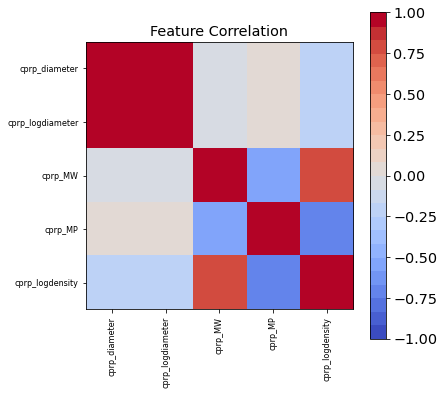

In [34]:
# Get feature correlation to determine best independent variable for imputation
def correlation_matrix(df):
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111)
    cmap = cm.get_cmap("coolwarm", 24)
    cax = ax.imshow(df.corr("spearman"), cmap=cmap, vmin=-1, vmax=1)
    plt.title("Feature Correlation")
    labels = df.columns.tolist()
    ax.set_xticks(range(len(df.columns)))
    ax.set_yticks(range(len(df.columns)))
    ax.set_xticklabels(labels, fontsize=8, rotation=90)
    ax.set_yticklabels(labels, fontsize=8)
    fig.colorbar(cax)
    plt.show()


correlation_matrix(X_enm.iloc[:, [35, 37, 0, 1, 2]])

In order to find missing values for diameter, imputation will be performed using linear regression. Log(Density) has the highest correlation with diameter and will therefore be used as the independent variable.
Assuming the line of best fit for a set of points is given by:

$y = a + b x$

where:

$b = \Large{\frac{\sum x_i  y_i - n \bar x\bar y )} {\sum (x_i - \bar x)^2}} $

and

$a = \bar y - b \bar x$

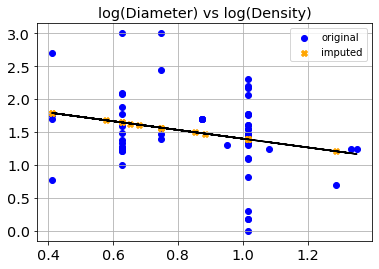

In [35]:
# TODO: Implement using https://sklearn.org/modules/generated/sklearn.preprocessing.Imputer.html#sklearn.preprocessing.Imputer
# Find line of best fit for imputation

# MP and density arrays for continuous data
X = np.array(X_enm.loc[X_enm.cprp_logdiameter.notnull(), ["cprp_logdensity"]])
Y = np.array(X_enm.loc[X_enm.cprp_logdiameter.notnull(), ["cprp_logdiameter"]])

# Solve for 'a' and 'b'
def best_fit(X, Y):
    xbar = sum(X) / len(X)
    ybar = sum(Y) / len(Y)
    n = len(X)  # or len(Y)
    numer = sum(xi * yi for xi, yi in zip(X, Y)) - n * xbar * ybar
    denum = sum(xi ** 2 for xi in X) - n * xbar ** 2
    b = numer / denum
    a = ybar - b * xbar
    return a, b


a, b = best_fit(X, Y)

# log(density) and log(diameter) arrays for missing data
X_null = np.array(X_enm.loc[X_enm.cprp_logdiameter.isnull(), ["cprp_logdensity"]])
Y_null = b * X_null + a

# Plot points and fit line
fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(X, Y, c="b", label="original")
ax1.scatter(X_null, Y_null, c="orange", marker="X", label="imputed")
yfit = [a + b * xi for xi in X]
ax1.plot(X, yfit, color="black")

plt.title("log(Diameter) vs log(Density)")
plt.legend(loc="upper right")
plt.grid()
plt.show()

blt.savepdf(fig, "logdiameter_logdensity")

In [36]:
# Put imputed densities into data frame
for idx in X_enm.index:
    if pd.isnull(X_enm.loc[idx, "cprp_diameter"]):
        logDens = X_enm.loc[idx, "cprp_logdensity"]
        X_enm.loc[idx, "cprp_diameter"] = 10 ** (b * logDens + a)

In [37]:
X_enm.iloc[:, [35, 36, 37, 0, 1, 2]]

,cprp_diameter,cprp_isdiamprovided,cprp_logdiameter,cprp_MW,cprp_MP,cprp_logdensity
0,44.454118,0,NaN,79.867,1843.00,0.626340
1,20.000000,1,1.301030,63.546,1083.00,0.952308
2,31.398784,0,NaN,65.370,419.53,0.853698
3,1.500000,1,0.176091,107.868,961.78,1.014730
4,1.500000,1,0.176091,107.868,961.78,1.014730
...,...,...,...,...,...,...
107,35.000000,1,1.544068,107.868,961.78,1.014730
108,30.000000,1,1.477121,107.868,961.78,1.014730
109,40.000000,1,1.602060,107.868,961.78,1.014730
110,24.545033,0,NaN,107.868,961.78,1.014730


#### Apply alternate variables

We will be using "diameter" and molar volume as alternative features for MW (which must also replace density, as this is used in the equation). For comparison with the measured diameters of ENM, the effective "diameter" of an organic compound (assumed to be spherical), $d_{org}$, is calculated as such:

$$m = \frac{M}{N_A} n $$ <br>
$$m = \frac{\pi}{6} \rho d_{org}^3 n $$ <br>
$$d_{org} = \sqrt[3]{\frac{6M}{\pi \rho N_A}} $$ <br>

where $m$ is the mass of a pure material in grams; $M$ is its molecular weight in grams per mole; $N_A = 6.022\mathrm{E}{23}$ molecules per mole, or Avagadros number; $n$ is the number of molecules; and $\rho$ is density in grams per cubic centimeter.

Molar volume, $V_N$, is easily calculated from the above.

$$ V_{N_{org}} = d_{org}^3 N_A = \frac{6M}{\pi\rho} $$ <br>
$$V_{N_{ENM}} = d_{ENM}^3 N_{ENM} = \frac{6M}{\pi\rho} $$ <br>

The constants may be ignored, simplifying to:

$$V_{N_{org}} = \frac{M}{\rho} $$ <br>
$$V_{N_{ENM}} = \frac{M}{\rho} $$ <br>

In [38]:
from scipy import constants


def diameterorg(MW, density):
    diam = ((6 * MW) / (math.pi * density * constants.N_A)) ** (1.0 / 3)
    return diam


def molvolume(MW, density):
    MV = MW / density
    return MV

In [39]:
# Undo log tranformation of density
X_enm["cprp_density"] = 10 ** X_enm["cprp_logdensity"]
X_source["cprp_density"] = 10 ** X_source["cprp_logdensity"]

# Apply new functions to datasets
X_source["cprp_diameter"] = diameterorg(X_source["cprp_MW"], X_source["cprp_density"])
X_source["cprp_isdiamprovided"] = 0
X_enm["cprp_MV"] = molvolume(X_enm["cprp_MW"], X_enm["cprp_density"])
X_source["cprp_MV"] = molvolume(X_source["cprp_MW"], X_source["cprp_density"])

In [40]:
# Create alternative datasets
cols_new = X_enm.columns.tolist()
cols_diam = (
    [cols_new[-5]]
    + [cols_new[-4]]  # 'cprp_diameter'
    + [cols_new[1]]  # 'cprp_isdiamprovided'
    + cols_new[3:-5]  # 'cprp_MP'
)  # all other features
cols_MV = (
    [cols_new[-1]] + [cols_new[1]] + cols_new[3:-5]  # 'cprp_MV'  # 'cprp_MP'
)  # all other features

X_enm_diam = pd.DataFrame(X_enm[cols_diam])
X_enm_MV = pd.DataFrame(X_enm[cols_MV])
X_enm = pd.DataFrame(X_enm[cols_orig])

X_source_diam = pd.DataFrame(X_source[cols_diam])
X_source_MV = pd.DataFrame(X_source[cols_MV])
X_source = pd.DataFrame(X_source[cols_orig])

y_enm_diam = pd.DataFrame(y_enm)
idx = X_enm_diam.index.values.tolist()
y_enm_diam = y_enm_diam.iloc[idx, :]

In [41]:
# Convert ENM diameter units from nanometers to centimeters
X_enm_diam["cprp_diameter"] = X_enm_diam["cprp_diameter"] / 1000000

In [42]:
X_enm.head(10)

,cprp_MW,cprp_MP,cprp_logdensity,fagg_absorbent_opacifier,fagg_brightener_viscositymodifier,fagg_filler_humectant,func_UVstabilizer,func_antiadhesivecohesive,func_antioxidant,func_antiredepositionagent,...,pgrp_dentalcare,pgrp_deodorant,pgrp_facialcleansingmoisturizing,pgrp_footcare,pgrp_generalmoisturizing,pgrp_makeuprelated,pgrp_surfacesealers,mtrx_spray,mtrx_formulation,mtrx_WFmeasured
0,79.867,1843.00,0.626340,0.0,0.5,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0
1,63.546,1083.00,0.952308,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0
2,65.370,419.53,0.853698,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0
3,107.868,961.78,1.014730,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,1,0
4,107.868,961.78,1.014730,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0
5,107.868,961.78,1.014730,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0
6,107.868,961.78,1.014730,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0
7,107.868,961.78,1.014730,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0
8,107.868,961.78,1.014730,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0
9,107.868,961.78,1.014730,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0


## Apply WF bins

Labels (continuous WF data) will be binned into low (0.0-0.0001), medium (0.0001-0.01) and high (0.01-1.0) categories.

In [43]:
# Apply bins to ENM and organics data
bin_enm = np.asarray(y_enm.apply(blt.bins, axis=1))
bin_enm_diam = np.asarray(y_enm_diam.apply(blt.bins, axis=1))
bin_source = np.asarray(y_source.apply(blt.bins, axis=1))

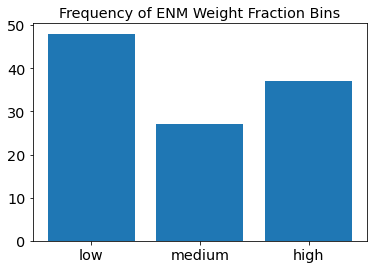

Label bin:  [0 1 2]
Count    :  [48 27 37]
Frequency:  [0.43, 0.24, 0.33]


In [44]:
# View bar plot of ENM WF bins
blt.bar_graph_bins(bin_enm, data_composition="ENM")

The medium WF bin has the least number of samples. This is important for evaluating models later on; the smallest bin size will be used for the number of cross validation folds so that it's essentially "leave-one-out" CV. This approach is, for the most part, considered unbiased.

https://stats.stackexchange.com/questions/154830/10-fold-cross-validation-vs-leave-one-out-cross-validation

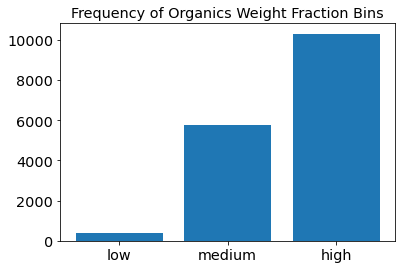

Label bin:  [0 1 2]
Count    :  [  381  5746 10312]
Frequency:  [0.02, 0.35, 0.63]


In [45]:
# View bar plot of Organics WF bins
blt.bar_graph_bins(bin_source, data_composition="Organics")

In [46]:
len(X_source)

16439

# ======CV PIPELINE TESTING======

This table summarizes what the cross validation pipeline does for each CV fold in terms of X/y and training/testing data. Because "Pipelines only transform the observed data (X)" (https://scikit-learn.org/stable/modules/compose.html) and here, the y training data must also be transformed in the data augmentation step, a custom Pipeline is used to supplement sklearn's.

|     Pipeline Step                |     X_train                    |     y_train              |     X_test (ENM only)    |     y_test (ENM only)    |
|----------------------------------|--------------------------------|--------------------------|--------------------------|--------------------------|
|     (1) Data augmentation        |     fit, transform(?) +mask    |     fit, transform(?)    |                          |                          |
|     (2) Feature agglomeration    |     fit, transform +mask       |                          |     transform            |                          |
|     (3) Min-max scaling          |     fit, transform             |                          |     transform            |                          |
|     (4) Classification           |     fit, predict               |     fit, predict         |     predict              |     predict              |

Unsupervised and supervised data augmentation rely on cosine similarity to determine which samples from the source dataset are most similar to each sample in the target dataset. 

$\text{cosine similarity} = \frac{A \cdotp B}{\parallel A \parallel \parallel B \parallel} $

We are assuming that the chemical properties of our source data are very different from our target data, so when looking for similar observations to pair, we want to exclude chemical properties from the similarity calculation by applying a *feature mask*. The mask will set chemical property features to zero so that they are effectively ignored by cosine similarity (only during data augmentation). Because chemical properties are the only features that aren't on a scale from 0 to 1, this also means we can perform data augmentation prior to min-max scaling in the cross validation pipeline.

Resource for writing custom sklearn transformers:
https://towardsdatascience.com/writing-custom-scikit-learn-transformers-e07a3cf7b559

In [64]:
import random as pyrandom
from numpy import random
from sklearn.metrics.pairwise import cosine_distances
from sklearn.preprocessing import MinMaxScaler

# TODO: These variables might cause problems if they're separate
# Define feature mask for data augmentation
feat_names = X_enm.columns
col_mask = ["cprp" not in name for name in feat_names]


# Functions for different data augmentation methods


def random_augment(k, X_source, y_source, random_state, X, y):
    """Randomly samples source data to pair with target data."""

    if k == 0:
        return X, y

    pyrandom.seed(random_state)
    np.random.seed(random_state)

    # Number of samples to select
    n_samples = k * len(X)
    # Obtain indices for randomly sampling source data
    idx_match = np.random.choice(len(X_source), n_samples)
    # Select matching rows from source data
    X_match = X_source.iloc[idx_match, :]
    y_match = y_source[idx_match]
    # Append sampled source data to target data
    X_aug = np.concatenate((X, X_match))
    y_aug = np.concatenate((y, y_match))
    assert (
        X_aug.shape[0] == y_aug.shape[0]
    ), f"X_aug.shape={X_aug.shape}, y_aug.shape={y_aug.shape}"

    return X_aug, y_aug


def unsupervised_augment(k, X_source, y_source, random_state, X, y):
    """
    Unsupervised data augmentation
    
    Match "k" most similar source data samples to target data samples 
    based on the smallest cosine distance between target and source data 
    samples (i.e., in an supervised fashion).
    """

    if k == 0:
        return X, y

    pyrandom.seed(random_state)
    np.random.seed(random_state)

    # Cosine distance matrix using feature mask
    cosdist_samples = cosine_distances(X_source * col_mask, X * col_mask)
    # Loop over distance matrix in search of k-smallest distances
    idx_match = []
    for col in cosdist_samples.T:
        # Find organics data indices of k-smallest distances
        matches = np.argpartition(col, k)[:k]
        idx_match.extend(matches)
    # Select matching rows from source data
    X_match = X_source.iloc[idx_match, :]
    y_match = y_source[idx_match]
    # Append sampled source data to target data
    X_aug = np.concatenate((X, X_match))
    y_aug = np.concatenate((y, y_match))

    return X_aug, y_aug


def supervised_augment(k, X_source, y_source, random_state, X, y):
    """
    Supervised data augmentation
    
    Match "k" most similar source data samples to target data samples 
    based on the smallest average of cosine distance between samples 
    and distance between WF labels (i.e., in an supervised fashion).
    """

    if k == 0:
        return X, y

    pyrandom.seed(random_state)
    np.random.seed(random_state)

    # Cosine distance matrix using feature mask
    cosdist_samples = cosine_distances(X_source * col_mask, X * col_mask)
    # For supervised matching augmentation, also consider WF labels
    # Turn 1D label arrays into 2D arrays
    y_2d = np.tile(y, (len(y_source), 1))
    y_source_2d = np.tile(y_source, (len(y), 1)).transpose()
    # Get normalized distance between ENM and organics labels
    scaler = MinMaxScaler()
    dist_y = scaler.fit_transform(np.abs(y_2d - y_source_2d).astype(float))
    # Average distances of features and labels
    dist_matrix = (0.95 * cosdist_samples) + (0.05 * dist_y)
    # Loop over distance matrix in search of k-smallest distances
    idx_match = []
    for col in dist_matrix.T:
        # Find organics data indices of k-smallest distances
        matches = np.argpartition(col, k)[:k]
        idx_match.extend(matches)
    # Select matching rows from source data
    X_match = X_source.iloc[idx_match, :]
    y_match = y_source[idx_match]
    # Append sampled source data to target data
    X_aug = np.concatenate((X, X_match))
    y_aug = np.concatenate((y, y_match))

    return X_aug, y_aug

In [29]:
# Augmented pipeline within Pipeline

random_state = 1922
augmentation_kwargs = {
    "augmentation_random_state": random_state,
    "augmentation_X_source": X_source,
    "augmentation_y_source": bin_source,
}

models = {
    "RandomForestClassifier": AugmentingPipeline(
        [
            ("scale", MinMaxScaler()),  # normalization from 0 to 1
            (
                "estimator",
                RandomForestClassifier(
                    class_weight="balanced", random_state=random_state
                ),
            ),
        ],
        **augmentation_kwargs
    ),
    "SVC": AugmentingPipeline(
        [
            ("scale", MinMaxScaler()),  # normalization from 0 to 1
            (
                "estimator",
                SVC(
                    kernel="rbf",
                    class_weight="balanced",  # balance by class size
                    random_state=random_state,
                ),
            ),
        ],
        **augmentation_kwargs
    ),
}
params = {
    "RandomForestClassifier": {
        "augmentation_type": [random_augment, unsupervised_augment, supervised_augment],
        "augmentation_k": [0, 1, 2, 3, 4, 5, 10, 20],
        "estimator__max_depth": np.arange(2, 15, 2),
    },
    "SVC": {
        "augmentation_type": [random_augment, unsupervised_augment, supervised_augment],
        "augmentation_k": [0, 1, 2, 3, 4, 5, 10, 20],
        "estimator__C": np.logspace(-1, 7, 9),
        "estimator__gamma": np.logspace(-7, 1, 9),
    },
}

In [30]:
results_prelim = apply_model_opt(
    models, params, X_target=X_enm, y_target=bin_enm, cust_folds=10
)

Running GridSearchCV for RandomForestClassifier.
Fitting 10 folds for each of 168 candidates, totalling 1680 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    4.5s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:   14.6s
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:   35.0s
[Parallel(n_jobs=3)]: Done 794 tasks      | elapsed:  1.2min
[Parallel(n_jobs=3)]: Done 1244 tasks      | elapsed:  2.1min
[Parallel(n_jobs=3)]: Done 1680 out of 1680 | elapsed:  3.0min finished


Running GridSearchCV for SVC.
Fitting 10 folds for each of 1944 candidates, totalling 19440 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done 146 tasks      | elapsed:    2.4s
[Parallel(n_jobs=3)]: Done 746 tasks      | elapsed:   11.6s
[Parallel(n_jobs=3)]: Done 1746 tasks      | elapsed:   25.8s
[Parallel(n_jobs=3)]: Done 3146 tasks      | elapsed:   46.6s
[Parallel(n_jobs=3)]: Done 4946 tasks      | elapsed:  1.9min
[Parallel(n_jobs=3)]: Done 7089 tasks      | elapsed:  3.1min
[Parallel(n_jobs=3)]: Done 8782 tasks      | elapsed:  4.3min
[Parallel(n_jobs=3)]: Done 10517 tasks      | elapsed:  6.1min
[Parallel(n_jobs=3)]: Done 12135 tasks      | elapsed:  7.5min
[Parallel(n_jobs=3)]: Done 14161 tasks      | elapsed:  9.6min
[Parallel(n_jobs=3)]: Done 15404 tasks      | elapsed: 17.3min
[Parallel(n_jobs=3)]: Done 16554 tasks      | elapsed: 18.8min
[Parallel(n_jobs=3)]: Done 17804 tasks      | elapsed: 54.4min
[Parallel(n_jobs=3)]: Done 19154 tasks      | elapsed: 63.4min
[Parallel(n_jobs=3)]: Done 19440 out of 19440 | elap

RandomForestClassifier
SVC


In [31]:
# Export preliminary results table to .csv
results_prelim.to_csv(
    "./data/results-prelim.csv", sep="\t", header="infer", na_rep="NaN", index=False
)

In [56]:
results_prelim.columns = results_prelim.columns = [
    col.split("__")[-1] for col in results_prelim.columns
]

In [57]:
# Filter results by performance and sort
res_top = results_prelim.drop_duplicates(
    subset=["estimator", "augmentation_k", "augmentation_type"], keep="first"
)
# res_top["augmentation_type"] = [
#    str(i).split(" ")[1] for i in res_top.loc[:, "augmentation_type"]
# ]
res_top = res_top.sort_values(
    by=["estimator", "augmentation_type", "augmentation_k"],
    ascending=[False, True, True],
)
res_top

,estimator,min_score,mean_score,max_score,std_score,augmentation_k,augmentation_type,max_depth,C,gamma
3,SVC,0.350000,0.711667,1.000000,0.194800,0,random_augment,NaN,10.0,0.10000
85,SVC,0.350000,0.672222,1.000000,0.195063,1,random_augment,NaN,10000000.0,0.01000
65,SVC,0.327778,0.678333,1.000000,0.204961,2,random_augment,NaN,10000000.0,0.00100
7,SVC,0.350000,0.705556,1.000000,0.206589,3,random_augment,NaN,10000000.0,0.10000
12,SVC,0.366667,0.701667,1.000000,0.172831,4,random_augment,NaN,1000.0,0.10000
8,SVC,0.233333,0.703889,0.933333,0.206888,5,random_augment,NaN,1000.0,0.10000
318,SVC,0.444444,0.647778,0.933333,0.139647,10,random_augment,NaN,10000000.0,0.00100
10,SVC,0.311111,0.703333,1.000000,0.196013,20,random_augment,NaN,100.0,0.10000
5,SVC,0.350000,0.711667,1.000000,0.194800,0,supervised_augment,NaN,10.0,0.10000
22,SVC,0.350000,0.691111,1.000000,0.196798,1,supervised_augment,NaN,10.0,0.10000


### Model Evaluation

{'C': 1.0, 'gamma': 1.0}
SVC_3_unsupervised_augment
Normalized Confusion Matrix
[[0.9  0.08 0.02]
 [0.38 0.52 0.11]
 [0.08 0.21 0.71]]


,estimator,augmentation_type,augmentation_k,score_avg,score_list,std_err
0,SVC,unsupervised_augment,3,0.708889,"[0.7344444444444445, 0.6833333333333333]","[0.05011509387145609, 0.03861455264882478]"


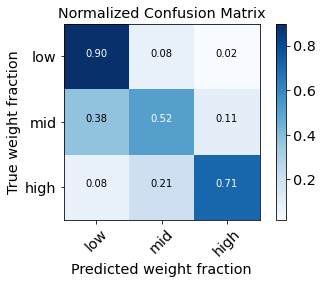

In [443]:
blt.run_hyperparams(
    results_prelim.iloc[:1, :],
    cust_folds=10,
    random_state=np.arange(2),
    show_feat_impt=False,
)

In [49]:
# import statistics


# def pick_params(df, cls_params, by_mode=False):
#    """Select best classifier parameters from training results."""

#    if not isinstance(cls_params, list):
#        cls_params = [cls_params]
#    cls_params = [col.split("__")[-1] for col in cls_params]
#    df.columns = [col.split("__")[-1] for col in df.columns]

#    if by_mode:
#        # Select hyperparameters based on mode of best parameters for all models
#        best = statistics.mode(
#            [row for row in df[cls_params].dropna().itertuples(index=False)]
#        )
#        return dict(best._asdict())
#    else:
#        # Select parameters based on best performing model
#        df = df.dropna(subset=cls_params)
#        best = df.loc[df["mean_score"].idxmax(), cls_params]

#        return best.to_dict()

In [50]:
# Augmented pipeline within Pipeline
# rfc_kwargs = pick_params(res_top, "max_depth", by_mode=False)
# svc_kwargs = pick_params(res_top, ["C", "gamma"], by_mode=False)
# augmentation_kwargs = {
#    "augmentation_X_source": X_source,
#    "augmentation_y_source": bin_source,
# }
# print("Best RFC params:", rfc_kwargs)
# print("Best SVC params:", svc_kwargs)

In [73]:
# Export final results table to .csv
results_final.to_csv(
    "./data/results-final.csv", sep="\t", header="infer", na_rep="NaN", index=False
)

In [58]:
res_idx = pd.MultiIndex.from_frame(
    results_final.loc[:, ["estimator", "augmentation_type", "augmentation_k"]]
)
results_final = results_final.set_index(res_idx).drop(
    columns=["estimator", "augmentation_type", "augmentation_k"]
)

In [59]:
res_avg = results_final.groupby(["estimator", "augmentation_type", "augmentation_k"])[
    "mean_score"
].mean()
res_avg

estimator               augmentation_type     augmentation_k
RandomForestClassifier  random_augment        0                 0.670044
                                              1                 0.647800
                                              2                 0.647467
                                              3                 0.643622
                                              4                 0.644544
                                              5                 0.643778
                                              10                0.646944
                                              20                0.638444
                        supervised_augment    0                 0.673444
                                              1                 0.643856
                                              2                 0.643222
                                              3                 0.637278
                                              4                

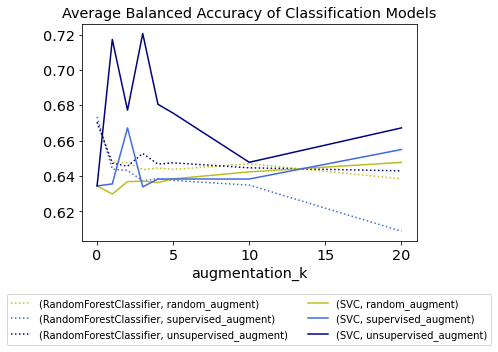

In [80]:
pltstyle = [":", ":", ":", "-", "-", "-"]
pltcolor = ["tab:olive", "royalblue", "navy"]
fig = res_avg.unstack(level=[0, 1]).plot(
    kind="line", subplots=False, style=pltstyle, color=pltcolor
)
plt.title("Average Balanced Accuracy of Classification Models")
plt.gca().legend(loc="lower center", bbox_to_anchor=(0.5, -0.5), ncol=2)
# blt.savepdf(fig, 'balancedaccuracyall')

In [65]:
# Params for model_eval
# SVC
# cls_kwargs = pick_params(res_top, ["C", "gamma"], by_mode=False)
# augmentation_kwargs = {
#    "augmentation_X_source": X_source,
#    "augmentation_y_source": bin_source,
# }
# classifier = SVC(kernel="rbf", class_weight="balanced", **cls_kwargs)
# params = {
#    "augmentation_type": [
#        random_augment,
#        unsupervised_augment,
#        supervised_augment,
#    ],  # TODO: one at a time
#    "augmentation_k": [0, 1, 2, 3, 4, 5, 10, 20],  # TODO: one at a time
#    "random_state": np.arange(50),
# }

In [66]:
# Params for model_eval
# RFC
# cls_kwargs = pick_params(res_top, "max_depth", by_mode=False)
# augmentation_kwargs = {
#    "augmentation_X_source": X_source,
#    "augmentation_y_source": bin_source,
# }
# classifier = RandomForestClassifier(class_weight="balanced", **cls_kwargs)
# params = {
#    "augmentation_type": [
#        random_augment,
#        unsupervised_augment,
#        supervised_augment,
#    ],  # TODO: one at a time
#    "augmentation_k": [0, 1, 2, 3, 4, 5, 10, 20],  # TODO: one at a time
#    "random_state": np.arange(50),
# }

Avg. balanced accuracy:     0.678
[0.15585902 0.17978754 0.2321581  0.00595305 0.01497797 0.0122666
 0.04211404 0.00776207 0.00410578 0.00102297 0.02769286 0.00182764
 0.00651942 0.00827594 0.03206292 0.00201588 0.00416195 0.01551287
 0.01530203 0.06090341 0.01773246 0.01048932 0.00672223 0.01724736
 0.00578959 0.00827841 0.0044716  0.01642067 0.00314557 0.00072559
 0.00666096 0.00079976 0.02412934 0.01544048 0.03166458]
Normalized Confusion Matrix
[[0.88 0.08 0.05]
 [0.37 0.39 0.24]
 [0.08 0.16 0.77]]


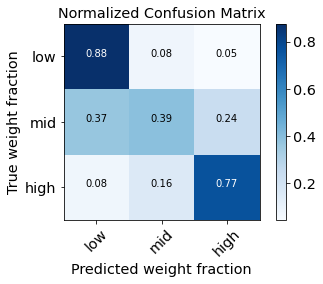

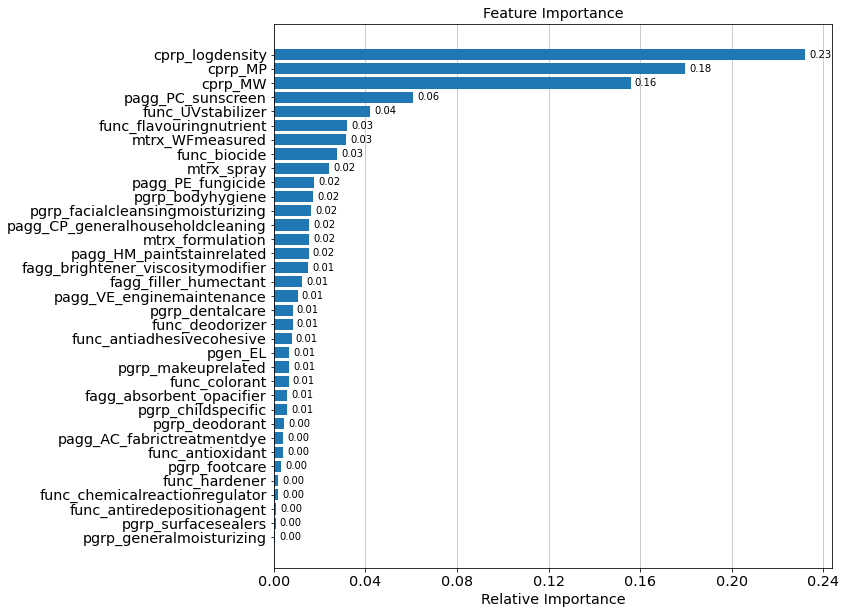

(0.6783867200533867,
 array([0.16, 0.18, 0.23, 0.01, 0.01, 0.01, 0.04, 0.01, 0.  , 0.  , 0.03,
        0.  , 0.01, 0.01, 0.03, 0.  , 0.  , 0.02, 0.02, 0.06, 0.02, 0.01,
        0.01, 0.02, 0.01, 0.01, 0.  , 0.02, 0.  , 0.  , 0.01, 0.  , 0.02,
        0.02, 0.03]))

In [67]:
# RFC example
cls_kwargs = {"max_depth": 10}
classifier = RandomForestClassifier(class_weight="balanced", **cls_kwargs)
blt.model_eval(
    classifier=classifier,
    augmentation_type=unsupervised_augment,  # variable
    augmentation_k=2,
    random_state=np.arange(5),
    cust_folds=10,
    save_fig_name="rfc_test",
    show_feat_impt=True,
    show_conf_matrix=True,
)

Avg. balanced accuracy:     0.645
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Normalized Confusion Matrix
[[0.96 0.03 0.01]
 [0.48 0.36 0.16]
 [0.14 0.24 0.62]]


0.6451701701701702

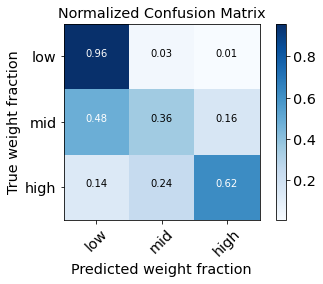

In [68]:
# SVC example
cls_kwargs = {"C": 100, "gamma": 0.01}
classifier = SVC(kernel="rbf", class_weight="balanced", **cls_kwargs)
blt.model_eval(
    classifier=classifier,
    augmentation_type=unsupervised_augment,  # variable
    augmentation_k=5,
    random_state=np.arange(5),
    cust_folds=10,
    save_fig_name="svc_test",
    show_feat_impt=False,
    show_conf_matrix=True,
)

# Model setup

The main prediction model function, <b>blt.model_opt_exe</b>, optimizes, executes and evaluates a classifier using stratified CV. It has the option to augment the training data within the pipeline. It is defined in an external file called at the beginning of this script.

The first part of the <b>blt.model_opt_exe</b> function runs a pipeline that normalizes features on a 0 to 1 scale then performs data augmentation and runs a classifer (SVC-RBF or RFC) using leave-one-out cross validation. Model parameters are optimized using a custom parameter grid search, with the optional aid of plots to visualize accuracy over the grid.

The final pipeline (trained using augmented data) is tested on the original ENM data using stratified cross-validation with n_folds = n_samples in the smallest WF bin--essentially leave-one-out CV (discussed earlier). A confusion matrix summarizes accuracy results according to each WF bin ("class"). The average normalized accuracy across all bins is then calculated from the confusion matrix and written to a results table for every data set.

# SVC-RBF Models

## ENM-only

### Baseline model

In [257]:
results_svc

,ENM-Organics-Ratio,Avg-Random-Augment,Std-Random-Augment,Avg-Unsupervised-Match,Std-Unsupervised-Match,Avg-Supervised-Match,Std-Supervised-Match
0,1:0*,0.403395,0.047404,NaN,NaN,NaN,NaN
1,1:0,0.703881,0.703881,0.703881,0.703881,NaN,NaN
2,1:1,0.667634,0.667634,0.708629,0.708629,0.697190,0.697190
3,1:2,0.667645,0.667645,0.687339,0.687339,0.660105,0.660105
4,1:3,0.657562,0.657562,0.703980,0.703980,0.671100,0.671100
5,1:4,0.680535,0.680535,0.712053,0.712053,0.668765,0.668765
6,1:5,0.683578,0.683578,0.712877,0.712877,0.674476,0.674476
7,1:10,0.589316,0.589316,0.647864,0.647864,0.657310,0.657310
8,1:20,0.700284,0.700284,0.681641,0.681641,0.679296,0.679296


{'augmentation_k': 0, 'augmentation_type': 'random_augment'}
{'C': 10.0, 'gamma': 0.1}
Avg. balanced accuracy:     0.704
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Normalized Confusion Matrix
[[0.83 0.13 0.04]
 [0.35 0.53 0.12]
 [0.08 0.16 0.76]]


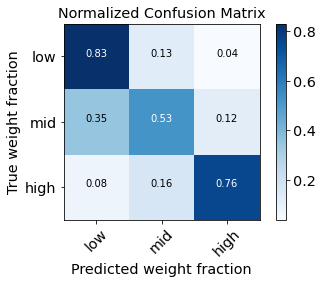

In [71]:
cls_kwargs = res_top.iloc[0, [8, 9]].to_dict()
classifier = SVC(kernel="rbf", class_weight="balanced", **cls_kwargs)
print(res_top.iloc[0, [5, 6]].to_dict())
print(cls_kwargs)
results_svc.iloc[1, 1:3] = blt.model_eval(
    classifier=classifier,
    augmentation_type=random_augment,
    augmentation_k=0,  # no augmentation
    random_state=np.arange(30),
    cust_folds=10,
    save_fig_name=None,
    show_feat_impt=False,
    show_conf_matrix=True,
)

{'augmentation_k': 0, 'augmentation_type': 'random_augment'}
{'C': 10.0, 'gamma': 0.1}
Avg. balanced accuracy:     0.704
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Normalized Confusion Matrix
[[0.83 0.13 0.04]
 [0.35 0.53 0.12]
 [0.08 0.16 0.76]]


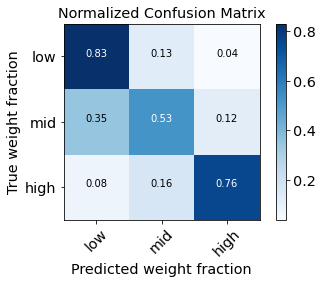

In [73]:
cls_kwargs = res_top.iloc[0, [8, 9]].to_dict()
classifier = SVC(kernel="rbf", class_weight="balanced", **cls_kwargs)
print(res_top.iloc[0, [5, 6]].to_dict())
print(cls_kwargs)
results_svc.iloc[1, 3:5] = blt.model_eval(
    classifier=classifier,
    augmentation_type=unsupervised_augment,
    augmentation_k=0,  # no augmentation
    random_state=np.arange(30),
    cust_folds=10,
    save_fig_name=None,
    show_feat_impt=False,
    show_conf_matrix=True,
)

### Permutation test

The following tests are performed with randomly permuted labels (ENM data only).

In [ ]:
bin_enm_permute = np.random.RandomState(seed=s).permutation(bin_enm)

In [ ]:
def perm_test(num_trials, classifier, model_params):
    seed_set = np.random.choice(np.arange(0,100), 
                                size=num_trials, replace=False)
    results_permute = np.empty(seed_set.size)
    for idx, s in enumerate(seed_set):
        with blt.HiddenPrints():
            
            results_permute[idx] = blt.model_opt_exe(classifier=classifier, 
                                                     aug_type='none', 
                                                     k=0, 
                                                     feat_data=X_enm, 
                                                     bin_data=bin_enm_permute,
                                                     param_grid=param_grid)
    mu_permute = results_permute.mean()
    sigma_permute = results_permute.std()
    print("Avg accuracy:    ", mu_permute)
    print("Median accuracy: ", np.median(results_permute))
    print("StdDev accuracy: ", sigma_permute)
    print("Numer of trials: ", num_trials)
    print("Results: ", results_permute)
    return mu_permute, sigma_permute

In [ ]:
# Run permutation tests over a number of trials, "num_trials"
num_trials = 100
param_grid = {'estimator__C': np.logspace(-1,7,9), 
              'estimator__gamma': np.logspace(-7,1,9)
             }
mu_permute, sigma_permute = perm_test(100, 'svc', model_params=param_grid)

In [ ]:
results_svc.iloc[0,1:3] = (mu_permute, sigma_permute)

In [ ]:
results_permute = [0.36, 0.39, 0.39, 0.45, 0.4, 0.42, 0.32, 0.48, 0.42, 0.43, 
                   0.34, 0.4, 0.38, 0.47, 0.34, 0.34, 0.41, 0.34, 0.34, 0.42, 
                   0.48, 0.35, 0.37, 0.41, 0.39, 0.38, 0.46, 0.47, 0.48, 0.39, 
                   0.45, 0.4, 0.43, 0.42, 0.41, 0.47, 0.41, 0.34, 0.38, 0.38, 
                   0.39, 0.35, 0.46, 0.44, 0.38, 0.35, 0.42, 0.37, 0.33, 0.44, 
                   0.39, 0.44, 0.47, 0.45, 0.39, 0.35, 0.43, 0.5, 0.34, 0.38, 
                   0.34, 0.43, 0.34, 0.36, 0.37, 0.54, 0.37, 0.34, 0.42, 0.49, 
                   0.41, 0.39, 0.35, 0.42, 0.46, 0.42, 0.43, 0.41, 0.43, 0.39, 
                   0.33, 0.38, 0.48, 0.36, 0.43, 0.34, 0.42, 0.45, 0.45, 0.47, 
                   0.33, 0.43, 0.42, 0.48, 0.38, 0.4, 0.44, 0.35, 0.4, 0.34]

In [ ]:
# Export permutation results to text file
np.savetxt('./data/results-permutation-SVC.txt', results_permute, 
           delimiter='\t', fmt='%.2f')

### Feature comparison

Next, model optimization and evaluation is performed on the clustered ENM-only data after it is separated by groups of features: functions, PUCs, chemical properties and matrix properties. This serves as a means of comparing the usefulness of the different feature groups while using an SVC-RBF. A similar comparison is made later by calculating feature importance with the RFC.

##### Only chemical properties

In [ ]:
# Get column indices for features present in Isaacs et al. 2016
feat_names = X_enm.columns
idx_cprponly = [i for i, s in enumerate(feat_names) if 'cprp' in s]

In [ ]:
model_params = {'classifier': 'svc', 
                'aug_type': 'none', 
                'k': 0, 
                'feat_data': X_enm.iloc[:,idx_cprponly], 
                'bin_data': bin_enm, 
                'use_balanced_accu': True, 
                'param_grid': {'estimator__C': np.logspace(-1,7,9), 
                               'estimator__gamma': np.logspace(-7,1,9)}
               }
mu_func, sigma_func = blt.multi_trials(num_trials=30, 
                                       model_params=model_params, 
                                       print_results=True)

##### Only functional uses

In [ ]:
# Get column indices for features present in Isaacs et al. 2016
idx_funconly = [i for i, s in enumerate(feat_names) if 'fagg' in s]
idx_funconly += [i for i, s in enumerate(feat_names) if 'func' in s]
idx_funconly

In [ ]:
model_params = {'classifier': 'svc', 
                'aug_type': 'none', 
                'k': 0, 
                'feat_data': X_enm.iloc[:,idx_funconly], 
                'bin_data': bin_enm, 
                'use_balanced_accu': True, 
                'param_grid': {'estimator__C': np.logspace(-1,7,9), 
                               'estimator__gamma': np.logspace(-7,1,9)}
               }
mu_func, sigma_func = blt.multi_trials(num_trials=30, 
                                       model_params=model_params, 
                                       print_results=True)

##### Only chemical properties, functional uses

In [ ]:
# Get column indices for features present in Isaacs et al. 2016
feat_names = X_enm.columns
idx_isaacs = [i for i, s in enumerate(feat_names) if 'cprp' in s]
idx_isaacs += [i for i, s in enumerate(feat_names) if 'fagg' in s]
idx_isaacs += [i for i, s in enumerate(feat_names) if 'func' in s]
idx_isaacs

In [ ]:
model_params = {'classifier': 'svc', 
                'aug_type': 'none', 
                'k': 0, 
                'feat_data': X_enm.iloc[:,idx_isaacs], 
                'bin_data': bin_enm, 
                'use_balanced_accu': True, 
                'param_grid': {'estimator__C': np.logspace(-1,7,9), 
                               'estimator__gamma': np.logspace(-7,1,9)}
               }
mu_func, sigma_func = blt.multi_trials(num_trials=30, 
                                       model_params=model_params, 
                                       print_results=True)

##### No 'was_WF_measured'

In [ ]:
idx_nomeas = [i for i, s in enumerate(feat_names) if 'WFmeasured' not in s]
model_params = {'classifier': 'svc', 
                'aug_type': 'none', 
                'k': 0, 
                'feat_data': X_enm.iloc[:,idx_nomeas], 
                'bin_data': bin_enm, 
                'use_balanced_accu': True, 
                'param_grid': {'estimator__C': np.logspace(-1,7,9), 
                               'estimator__gamma': np.logspace(-7,1,9)}
               }
blt.multi_trials(num_trials=30, 
                 model_params=model_params, 
                 print_results=True)

##### No PUCs 

In [ ]:
# Get column indices excluding those of PUCs
counting = np.arange(0,35)
lst = list(counting[:16]) + list(counting[-3:])
lst

In [ ]:
model_params = {'classifier': 'svc', 
                'aug_type': 'none', 
                'k': 0, 
                'feat_data': X_enm.iloc[:,lst], 
                'bin_data': bin_enm, 
                'param_grid': {'estimator__C': np.logspace(-1,7,9), 
                               'estimator__gamma': np.logspace(-7,1,9)}
               }
mu_func, sigma_func = blt.multi_trials(num_trials=30, 
                                       model_params=model_params)

## Organics-only

In [ ]:
# Run model_opt_exe on clustered organics-only data
param_grid = {'estimator__C': np.logspace(-1,7,9), 
              'estimator__gamma': np.logspace(-7,1,9)
             }
blt.model_opt_exe(classifier='svc', 
                  aug_type='none', 
                  k=0, 
                  feat_data=X_source, 
                  bin_data=bin_source, 
                  show_opt_plot=True, param_grid=param_grid)

## Randomly augmented data
The remaining models use augmented training data.

In [74]:
results_svc

,ENM-Organics-Ratio,Avg-Random-Augment,Std-Random-Augment,Avg-Unsupervised-Match,Std-Unsupervised-Match,Avg-Supervised-Match,Std-Supervised-Match
0,1:0*,0.403395,0.047404,NaN,NaN,NaN,NaN
1,1:0,0.703881,0.703881,0.703881,0.703881,NaN,NaN
2,1:1,0.703881,0.703881,0.732000,0.008000,0.713,0.012
3,1:2,0.667645,0.667645,0.719000,0.008000,0.694,0.008
4,1:3,0.657562,0.657562,0.739000,0.009000,0.716,0.007
5,1:4,0.680535,0.680535,0.735000,0.010000,0.729,0.010
6,1:5,0.683578,0.683578,0.757000,0.011000,0.721,0.007
7,1:10,0.589316,0.589316,0.751000,0.007000,0.728,0.010
8,1:20,0.710000,0.017000,0.711000,0.010000,0.702,0.010


{'augmentation_k': 1, 'augmentation_type': 'random_augment'}
{'C': 10000000.0, 'gamma': 0.01}
Avg. balanced accuracy:     0.668
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Normalized Confusion Matrix
[[0.86 0.09 0.04]
 [0.37 0.41 0.22]
 [0.1  0.17 0.73]]


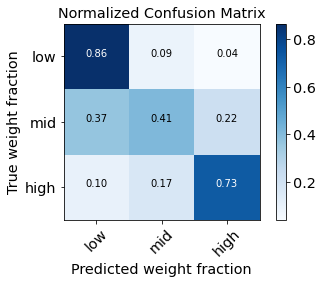

In [75]:
# 1:1 ENM:Organics ratio
q = 1
cls_kwargs = res_top.iloc[q, [8, 9]].to_dict()
classifier = SVC(kernel="rbf", class_weight="balanced", **cls_kwargs)
print(res_top.iloc[q, [5, 6]].to_dict())
print(cls_kwargs)
results_svc.iloc[2, 1:3] = blt.model_eval(
    classifier=classifier,
    augmentation_type=random_augment,  # variable
    augmentation_k=q,  # variable
    random_state=np.arange(30),
    cust_folds=10,
    save_fig_name=None,
    show_feat_impt=False,
    show_conf_matrix=True,
)

{'augmentation_k': 2, 'augmentation_type': 'random_augment'}
{'C': 10000000.0, 'gamma': 0.001}
Avg. balanced accuracy:     0.668
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Normalized Confusion Matrix
[[0.85 0.11 0.04]
 [0.36 0.45 0.19]
 [0.13 0.17 0.7 ]]


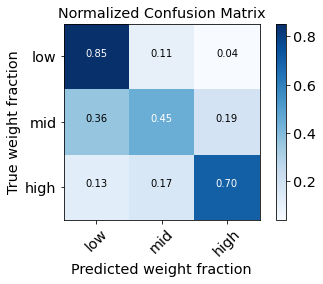

In [300]:
# 1:2 ENM:Organics ratio
q = 2
cls_kwargs = res_top.iloc[q, [8, 9]].to_dict()
classifier = SVC(kernel="rbf", class_weight="balanced", **cls_kwargs)
print(res_top.iloc[q, [5, 6]].to_dict())
print(cls_kwargs)
results_svc.iloc[3, 1:3] = blt.model_eval(
    classifier=classifier,
    augmentation_type=random_augment,  # variable
    augmentation_k=q,  # variable
    random_state=np.arange(30),
    cust_folds=10,
    save_fig_name=None,
    show_feat_impt=False,
    show_conf_matrix=True,
)

{'augmentation_k': 3, 'augmentation_type': 'random_augment'}
{'C': 10000000.0, 'gamma': 0.1}
Avg. balanced accuracy:     0.658
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Normalized Confusion Matrix
[[0.84 0.1  0.06]
 [0.37 0.4  0.23]
 [0.14 0.12 0.74]]


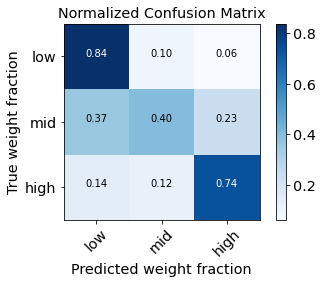

In [301]:
# 1:3 ENM:Organics ratio
q = 3
cls_kwargs = res_top.iloc[q, [8, 9]].to_dict()
classifier = SVC(kernel="rbf", class_weight="balanced", **cls_kwargs)
print(res_top.iloc[q, [5, 6]].to_dict())
print(cls_kwargs)
results_svc.iloc[4, 1:3] = blt.model_eval(
    classifier=classifier,
    augmentation_type=random_augment,  # variable
    augmentation_k=q,  # variable
    random_state=np.arange(30),
    cust_folds=10,
    save_fig_name=None,
    show_feat_impt=False,
    show_conf_matrix=True,
)

{'augmentation_k': 4, 'augmentation_type': 'random_augment'}
{'C': 1000.0, 'gamma': 0.1}
Avg. balanced accuracy:     0.681
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Normalized Confusion Matrix
[[0.85 0.11 0.04]
 [0.33 0.47 0.19]
 [0.11 0.17 0.72]]


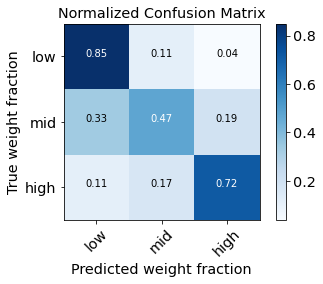

In [302]:
# 1:4 ENM:Organics ratio
q = 4
cls_kwargs = res_top.iloc[q, [8, 9]].to_dict()
classifier = SVC(kernel="rbf", class_weight="balanced", **cls_kwargs)
print(res_top.iloc[q, [5, 6]].to_dict())
print(cls_kwargs)
results_svc.iloc[5, 1:3] = blt.model_eval(
    classifier=classifier,
    augmentation_type=random_augment,  # variable
    augmentation_k=q,  # variable
    random_state=np.arange(30),
    cust_folds=10,
    save_fig_name=None,
    show_feat_impt=False,
    show_conf_matrix=True,
)

{'augmentation_k': 5, 'augmentation_type': 'random_augment'}
{'C': 1000.0, 'gamma': 0.1}
Avg. balanced accuracy:     0.684
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Normalized Confusion Matrix
[[0.84 0.11 0.05]
 [0.33 0.49 0.18]
 [0.12 0.17 0.72]]


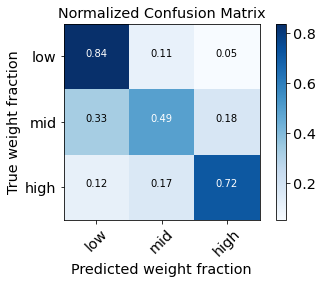

In [303]:
# 1:5 ENM:Organics ratio
q = 5
cls_kwargs = res_top.iloc[q, [8, 9]].to_dict()
classifier = SVC(kernel="rbf", class_weight="balanced", **cls_kwargs)
print(res_top.iloc[q, [5, 6]].to_dict())
print(cls_kwargs)
results_svc.iloc[6, 1:3] = blt.model_eval(
    classifier=classifier,
    augmentation_type=random_augment,  # variable
    augmentation_k=q,  # variable
    random_state=np.arange(30),
    cust_folds=10,
    save_fig_name=None,
    show_feat_impt=False,
    show_conf_matrix=True,
)

{'augmentation_k': 10, 'augmentation_type': 'random_augment'}
{'C': 10000000.0, 'gamma': 0.001}
Avg. balanced accuracy:     0.589
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Normalized Confusion Matrix
[[0.69 0.24 0.07]
 [0.31 0.48 0.2 ]
 [0.14 0.27 0.6 ]]


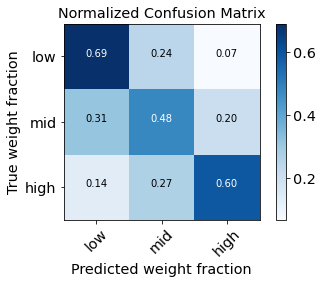

In [304]:
# 1:10 ENM:Organics ratio
q = 6
cls_kwargs = res_top.iloc[q, [8, 9]].to_dict()
classifier = SVC(kernel="rbf", class_weight="balanced", **cls_kwargs)
print(res_top.iloc[q, [5, 6]].to_dict())
print(cls_kwargs)
results_svc.iloc[7, 1:3] = blt.model_eval(
    classifier=classifier,
    augmentation_type=random_augment,  # variable
    augmentation_k=10,  # variable
    random_state=np.arange(30),
    cust_folds=10,
    save_fig_name=None,
    show_feat_impt=False,
    show_conf_matrix=True,
)

{'augmentation_k': 20, 'augmentation_type': 'random_augment'}
{'C': 100.0, 'gamma': 0.1}
Avg. balanced accuracy:     0.700
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Normalized Confusion Matrix
[[0.87 0.11 0.02]
 [0.34 0.53 0.13]
 [0.12 0.18 0.7 ]]


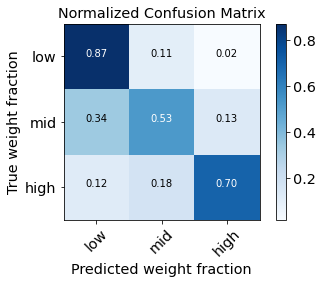

In [106]:
# 1:20 ENM:Organics ratio
q = 7
cls_kwargs = res_top.iloc[q, [8, 9]].to_dict()
classifier = SVC(kernel="rbf", class_weight="balanced", **cls_kwargs)
print(res_top.iloc[q, [5, 6]].to_dict())
print(cls_kwargs)
results_svc.iloc[8, 1:3] = blt.model_eval(
    classifier=classifier,
    augmentation_type=random_augment,  # variable
    augmentation_k=20,  # variable
    random_state=np.arange(30),
    cust_folds=10,
    save_fig_name=None,
    show_feat_impt=False,
    show_conf_matrix=True,
)

## Matching (unsupervised) augmented data

{'augmentation_k': 1, 'augmentation_type': 'unsupervised_augment'}
{'C': 1.0, 'gamma': 1.0}
Avg. balanced accuracy:     0.709
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Normalized Confusion Matrix
[[0.85 0.13 0.03]
 [0.37 0.56 0.07]
 [0.08 0.21 0.72]]


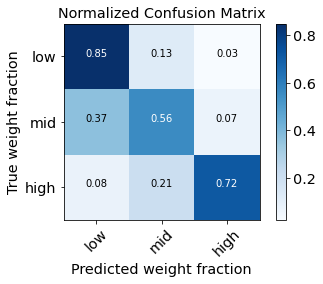

In [80]:
# 1:1 ENM:Organics ratio
q = 17
cls_kwargs = res_top.iloc[q, [8, 9]].to_dict()
classifier = SVC(kernel="rbf", class_weight="balanced", **cls_kwargs)
print(res_top.iloc[q, [5, 6]].to_dict())
print(cls_kwargs)
results_svc.iloc[2, 3:5] = blt.model_eval(
    classifier=classifier,
    augmentation_type=unsupervised_augment,  # variable
    augmentation_k=1,  # variable
    random_state=np.arange(30),
    cust_folds=10,
    save_fig_name=None,
    show_feat_impt=False,
    show_conf_matrix=True,
)

{'augmentation_k': 2, 'augmentation_type': 'unsupervised_augment'}
{'C': 100.0, 'gamma': 0.01}
Avg. balanced accuracy:     0.687
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Normalized Confusion Matrix
[[0.97 0.02 0.01]
 [0.4  0.45 0.14]
 [0.11 0.25 0.64]]


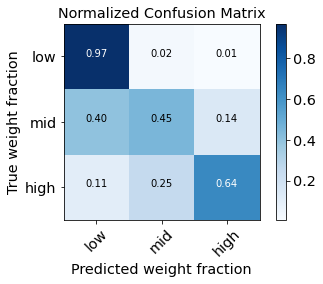

In [81]:
# 1:2 ENM:Organics ratio
q = 18
cls_kwargs = res_top.iloc[q, [8, 9]].to_dict()
classifier = SVC(kernel="rbf", class_weight="balanced", **cls_kwargs)
print(res_top.iloc[q, [5, 6]].to_dict())
print(cls_kwargs)
results_svc.iloc[3, 3:5] = blt.model_eval(
    classifier=classifier,
    augmentation_type=unsupervised_augment,  # variable
    augmentation_k=2,  # variable
    random_state=np.arange(30),
    cust_folds=10,
    save_fig_name=None,
    show_feat_impt=False,
    show_conf_matrix=True,
)

{'augmentation_k': 3, 'augmentation_type': 'unsupervised_augment'}
{'C': 1.0, 'gamma': 1.0}
Avg. balanced accuracy:     0.704
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Normalized Confusion Matrix
[[0.89 0.09 0.02]
 [0.39 0.51 0.1 ]
 [0.08 0.21 0.71]]


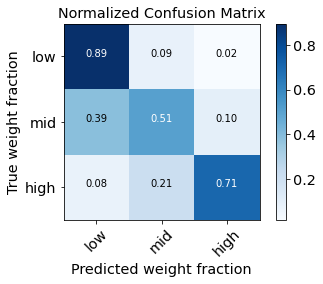

In [82]:
# 1:3 ENM:Organics ratio
q = 19
cls_kwargs = res_top.iloc[q, [8, 9]].to_dict()
classifier = SVC(kernel="rbf", class_weight="balanced", **cls_kwargs)
print(res_top.iloc[q, [5, 6]].to_dict())
print(cls_kwargs)
results_svc.iloc[4, 3:5] = blt.model_eval(
    classifier=classifier,
    augmentation_type=unsupervised_augment,  # variable
    augmentation_k=3,  # variable
    random_state=np.arange(30),
    cust_folds=10,
    save_fig_name=None,
    show_feat_impt=False,
    show_conf_matrix=True,
)

{'augmentation_k': 4, 'augmentation_type': 'unsupervised_augment'}
{'C': 1.0, 'gamma': 1.0}
Avg. balanced accuracy:     0.712
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Normalized Confusion Matrix
[[0.9  0.07 0.02]
 [0.37 0.5  0.13]
 [0.08 0.19 0.73]]


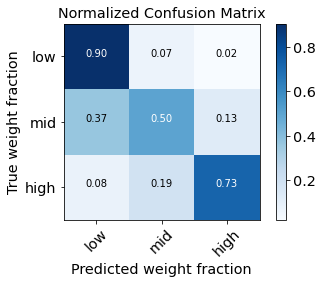

In [83]:
# 1:4 ENM:Organics ratio
q = 20
cls_kwargs = res_top.iloc[q, [8, 9]].to_dict()
classifier = SVC(kernel="rbf", class_weight="balanced", **cls_kwargs)
print(res_top.iloc[q, [5, 6]].to_dict())
print(cls_kwargs)
results_svc.iloc[5, 3:5] = blt.model_eval(
    classifier=classifier,
    augmentation_type=unsupervised_augment,  # variable
    augmentation_k=4,  # variable
    random_state=np.arange(30),
    cust_folds=10,
    save_fig_name=None,
    show_feat_impt=False,
    show_conf_matrix=True,
)

{'augmentation_k': 5, 'augmentation_type': 'unsupervised_augment'}
{'C': 1.0, 'gamma': 1.0}
Avg. balanced accuracy:     0.713
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Normalized Confusion Matrix
[[0.89 0.07 0.04]
 [0.38 0.55 0.07]
 [0.08 0.22 0.7 ]]


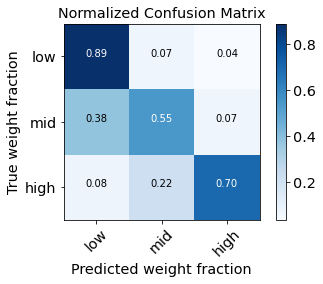

In [89]:
# 1:5 ENM:Organics ratio
q = 21
cls_kwargs = res_top.iloc[q, [8, 9]].to_dict()
classifier = SVC(kernel="rbf", class_weight="balanced", **cls_kwargs)
print(res_top.iloc[q, [5, 6]].to_dict())
print(cls_kwargs)
results_svc.iloc[6, 3:5] = blt.model_eval(
    classifier=classifier,
    augmentation_type=unsupervised_augment,  # variable
    augmentation_k=5,  # variable
    random_state=np.arange(30),
    cust_folds=10,
    save_fig_name=None,
    show_feat_impt=False,
    show_conf_matrix=True,
)

In [85]:
# TODO: get this for best model
match_distrib = [
    0.77,
    0.74,
    0.76,
    0.76,
    0.75,
    0.76,
    0.76,
    0.76,
    0.73,
    0.76,
    0.75,
    0.74,
    0.75,
    0.74,
    0.76,
    0.75,
    0.72,
    0.75,
    0.76,
    0.73,
    0.75,
    0.76,
    0.76,
    0.77,
    0.76,
    0.75,
    0.75,
    0.76,
    0.76,
    0.76,
    0.78,
    0.76,
    0.74,
    0.76,
    0.76,
    0.72,
    0.72,
    0.76,
    0.76,
    0.76,
    0.76,
    0.76,
    0.78,
    0.76,
    0.74,
    0.76,
    0.77,
    0.76,
    0.76,
    0.76,
]

{'augmentation_k': 10, 'augmentation_type': 'unsupervised_augment'}
{'C': 1000.0, 'gamma': 1.0}
Avg. balanced accuracy:     0.648
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Normalized Confusion Matrix
[[0.86 0.08 0.06]
 [0.37 0.29 0.33]
 [0.08 0.12 0.79]]


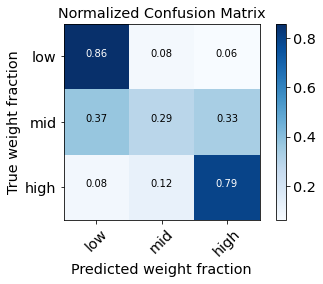

In [90]:
# 1:10 ENM:Organics ratio
q = 22
cls_kwargs = res_top.iloc[q, [8, 9]].to_dict()
classifier = SVC(kernel="rbf", class_weight="balanced", **cls_kwargs)
print(res_top.iloc[q, [5, 6]].to_dict())
print(cls_kwargs)
results_svc.iloc[7, 3:5] = blt.model_eval(
    classifier=classifier,
    augmentation_type=unsupervised_augment,  # variable
    augmentation_k=10,  # variable
    random_state=np.arange(30),
    cust_folds=10,
    save_fig_name=None,
    show_feat_impt=False,
    show_conf_matrix=True,
)

{'augmentation_k': 20, 'augmentation_type': 'unsupervised_augment'}
{'C': 1.0, 'gamma': 1.0}
Avg. balanced accuracy:     0.682
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Normalized Confusion Matrix
[[0.83 0.13 0.04]
 [0.37 0.5  0.14]
 [0.08 0.21 0.72]]


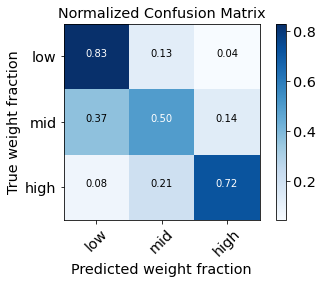

In [92]:
# 1:20 ENM:Organics ratio
q = 23
cls_kwargs = res_top.iloc[q, [8, 9]].to_dict()
classifier = SVC(kernel="rbf", class_weight="balanced", **cls_kwargs)
print(res_top.iloc[q, [5, 6]].to_dict())
print(cls_kwargs)
results_svc.iloc[8, 3:5] = blt.model_eval(
    classifier=classifier,
    augmentation_type=unsupervised_augment,  # variable
    augmentation_k=20,  # variable
    random_state=np.arange(30),
    cust_folds=10,
    save_fig_name=None,
    show_feat_impt=False,
    show_conf_matrix=True,
)

## Matching (supervised) augmented data

{'augmentation_k': 1, 'augmentation_type': 'supervised_augment'}
{'C': 10.0, 'gamma': 0.1}
Avg. balanced accuracy:     0.697
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Normalized Confusion Matrix
[[0.93 0.02 0.05]
 [0.42 0.42 0.17]
 [0.08 0.18 0.74]]


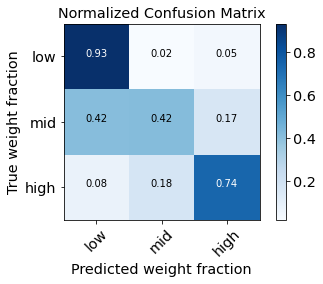

In [93]:
# 1:1 ENM:Organics ratio
q = 9
cls_kwargs = res_top.iloc[q, [8, 9]].to_dict()
classifier = SVC(kernel="rbf", class_weight="balanced", **cls_kwargs)
print(res_top.iloc[q, [5, 6]].to_dict())
print(cls_kwargs)
results_svc.iloc[2, 5:7] = blt.model_eval(
    classifier=classifier,
    augmentation_type=supervised_augment,  # variable
    augmentation_k=1,  # variable
    random_state=np.arange(30),
    cust_folds=10,
    save_fig_name=None,
    show_feat_impt=False,
    show_conf_matrix=True,
)

{'augmentation_k': 2, 'augmentation_type': 'supervised_augment'}
{'C': 10000.0, 'gamma': 0.1}
Avg. balanced accuracy:     0.660
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Normalized Confusion Matrix
[[0.88 0.08 0.04]
 [0.43 0.35 0.22]
 [0.1  0.15 0.75]]


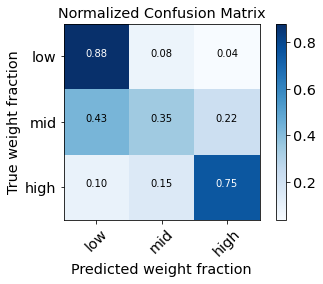

In [94]:
# 1:2 ENM:Organics ratio
q = 10
cls_kwargs = res_top.iloc[q, [8, 9]].to_dict()
classifier = SVC(kernel="rbf", class_weight="balanced", **cls_kwargs)
print(res_top.iloc[q, [5, 6]].to_dict())
print(cls_kwargs)
results_svc.iloc[3, 5:7] = blt.model_eval(
    classifier=classifier,
    augmentation_type=supervised_augment,  # variable
    augmentation_k=2,  # variable
    random_state=np.arange(30),
    cust_folds=10,
    save_fig_name=None,
    show_feat_impt=False,
    show_conf_matrix=True,
)

{'augmentation_k': 3, 'augmentation_type': 'supervised_augment'}
{'C': 100000.0, 'gamma': 0.01}
Avg. balanced accuracy:     0.671
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Normalized Confusion Matrix
[[0.86 0.1  0.03]
 [0.37 0.41 0.22]
 [0.12 0.15 0.74]]


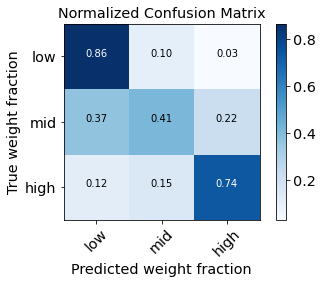

In [95]:
# 1:3 ENM:Organics ratio
q = 11
cls_kwargs = res_top.iloc[q, [8, 9]].to_dict()
classifier = SVC(kernel="rbf", class_weight="balanced", **cls_kwargs)
print(res_top.iloc[q, [5, 6]].to_dict())
print(cls_kwargs)
results_svc.iloc[4, 5:7] = blt.model_eval(
    classifier=classifier,
    augmentation_type=supervised_augment,  # variable
    augmentation_k=3,  # variable
    random_state=np.arange(30),
    cust_folds=10,
    save_fig_name=None,
    show_feat_impt=False,
    show_conf_matrix=True,
)

{'augmentation_k': 4, 'augmentation_type': 'supervised_augment'}
{'C': 100000.0, 'gamma': 0.01}
Avg. balanced accuracy:     0.669
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Normalized Confusion Matrix
[[0.86 0.11 0.03]
 [0.38 0.43 0.19]
 [0.1  0.17 0.72]]


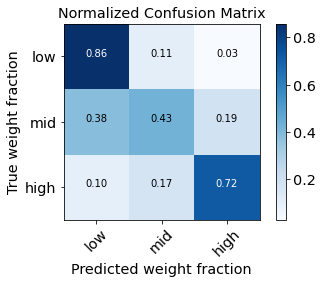

In [96]:
# 1:4 ENM:Organics ratio
q = 12
cls_kwargs = res_top.iloc[q, [8, 9]].to_dict()
classifier = SVC(kernel="rbf", class_weight="balanced", **cls_kwargs)
print(res_top.iloc[q, [5, 6]].to_dict())
print(cls_kwargs)
results_svc.iloc[5, 5:7] = blt.model_eval(
    classifier=classifier,
    augmentation_type=supervised_augment,  # variable
    augmentation_k=4,  # variable
    random_state=np.arange(30),
    cust_folds=10,
    save_fig_name=None,
    show_feat_impt=False,
    show_conf_matrix=True,
)

{'augmentation_k': 5, 'augmentation_type': 'supervised_augment'}
{'C': 100000.0, 'gamma': 1e-05}
Avg. balanced accuracy:     0.674
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Normalized Confusion Matrix
[[0.95 0.03 0.01]
 [0.46 0.38 0.16]
 [0.14 0.16 0.7 ]]


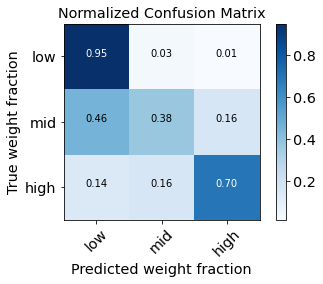

In [97]:
# 1:5 ENM:Organics ratio
q = 13
cls_kwargs = res_top.iloc[q, [8, 9]].to_dict()
classifier = SVC(kernel="rbf", class_weight="balanced", **cls_kwargs)
print(res_top.iloc[q, [5, 6]].to_dict())
print(cls_kwargs)
results_svc.iloc[6, 5:7] = blt.model_eval(
    classifier=classifier,
    augmentation_type=supervised_augment,  # variable
    augmentation_k=5,  # variable
    random_state=np.arange(30),
    cust_folds=10,
    save_fig_name=None,
    show_feat_impt=False,
    show_conf_matrix=True,
)

{'augmentation_k': 10, 'augmentation_type': 'supervised_augment'}
{'C': 10000.0, 'gamma': 0.1}
Avg. balanced accuracy:     0.657
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Normalized Confusion Matrix
[[0.9  0.05 0.06]
 [0.5  0.39 0.11]
 [0.13 0.18 0.69]]


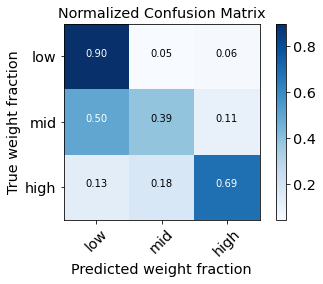

In [98]:
# 1:10 ENM:Organics ratio
q = 14
cls_kwargs = res_top.iloc[q, [8, 9]].to_dict()
classifier = SVC(kernel="rbf", class_weight="balanced", **cls_kwargs)
print(res_top.iloc[q, [5, 6]].to_dict())
print(cls_kwargs)
results_svc.iloc[7, 5:7] = blt.model_eval(
    classifier=classifier,
    augmentation_type=supervised_augment,  # variable
    augmentation_k=10,  # variable
    random_state=np.arange(30),
    cust_folds=10,
    save_fig_name=None,
    show_feat_impt=False,
    show_conf_matrix=True,
)

{'augmentation_k': 20, 'augmentation_type': 'supervised_augment'}
{'C': 100.0, 'gamma': 0.1}
Avg. balanced accuracy:     0.679
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Normalized Confusion Matrix
[[0.89 0.06 0.04]
 [0.37 0.41 0.23]
 [0.08 0.18 0.74]]


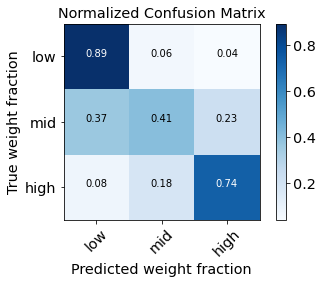

In [99]:
# 1:20 ENM:Organics ratio
q = 15
cls_kwargs = res_top.iloc[q, [8, 9]].to_dict()
classifier = SVC(kernel="rbf", class_weight="balanced", **cls_kwargs)
print(res_top.iloc[q, [5, 6]].to_dict())
print(cls_kwargs)
results_svc.iloc[8, 5:7] = blt.model_eval(
    classifier=classifier,
    augmentation_type=supervised_augment,  # variable
    augmentation_k=1,  # variable
    random_state=np.arange(30),
    cust_folds=20,
    save_fig_name=None,
    show_feat_impt=False,
    show_conf_matrix=True,
)

## Alternative to MW

### Diameter

In [ ]:
results_svc_diam

In [ ]:
# 30 trials SVC-RBF, diameter
model_params = {'classifier': 'svc', 
                'aug_type': 'none', 
                'k': 0, 
                'feat_data': X_enm_diam, 
                'bin_data': bin_enm_diam, 
                'use_balanced_accu': True, 
                'param_grid': {'estimator__C': np.logspace(-1,7,9), 
                               'estimator__gamma': np.logspace(-7,1,9)}
               }
results_svc_diam.iloc[0,1:3] = blt.multi_trials(num_trials=30, 
                                                model_params=model_params, 
                                                print_results=True)

#### Random augmentation

In [ ]:
# 30 trials SVC-RBF, diameter
model_params['aug_type'] = "random"
model_params['k'] = 1
results_svc_diam.iloc[1,1:3] = blt.multi_trials(num_trials=30, 
                                                model_params=model_params, 
                                                print_results=True)

In [ ]:
# 30 trials SVC-RBF, diameter
model_params['aug_type'] = "random"
model_params['k'] = 2
results_svc_diam.iloc[2,1:3] = blt.multi_trials(num_trials=30, 
                                                model_params=model_params, 
                                                print_results=True)

In [ ]:
# 30 trials SVC-RBF, diameter
model_params['aug_type'] = "random"
model_params['k'] = 3
results_svc_diam.iloc[3,1:3] = blt.multi_trials(num_trials=30, 
                                                model_params=model_params, 
                                                print_results=True)

In [ ]:
# 30 trials SVC-RBF, diameter
model_params['aug_type'] = "random"
model_params['k'] = 4
results_svc_diam.iloc[4,1:3] = blt.multi_trials(num_trials=30, 
                                                model_params=model_params, 
                                                print_results=True)

In [ ]:
# 30 trials SVC-RBF, diameter
model_params['aug_type'] = "random"
model_params['k'] = 5
results_svc_diam.iloc[5,1:3] = blt.multi_trials(num_trials=30, 
                                                model_params=model_params, 
                                                print_results=True)

In [ ]:
# 30 trials SVC-RBF, diameter
model_params['aug_type'] = "random"
model_params['k'] = 10
results_svc_diam.iloc[6,1:3] = blt.multi_trials(num_trials=30, 
                                                model_params=model_params, 
                                                print_results=True)

In [ ]:
# 30 trials SVC-RBF, diameter
model_params['k'] = 20
results_svc_diam.iloc[7,3:5] = blt.multi_trials(num_trials=30, 
                                                model_params=model_params, 
                                                print_results=True)

#### Unsupervised matching augmentation

In [ ]:
# 30 trials SVC-RBF, diameter
model_params['aug_type'] = "uns_match"
model_params['k'] = 1
results_svc_diam.iloc[1,3:5] = blt.multi_trials(num_trials=30, 
                                                model_params=model_params, 
                                                print_results=True)

In [ ]:
# 30 trials SVC-RBF, diameter
model_params['k'] = 2
results_svc_diam.iloc[2,3:5] = blt.multi_trials(num_trials=30, 
                                                model_params=model_params, 
                                                print_results=True)

In [ ]:
# 30 trials SVC-RBF, diameter
model_params = {'classifier': 'svc', 
                'aug_type': 'uns_match', 
                'k': 3, 
                'feat_data': X_enm_diam, 
                'bin_data': bin_enm_diam, 
                'use_balanced_accu': True, 
                'param_grid': {'estimator__C': np.logspace(-1,7,9), 
                               'estimator__gamma': np.logspace(-7,1,9)}
               }
model_params['k'] = 3
results_svc_diam.iloc[3,3:5] = blt.multi_trials(num_trials=30, 
                                                model_params=model_params, 
                                                print_results=True)

In [ ]:
# 30 trials SVC-RBF, diameter
model_params['k'] = 4
results_svc_diam.iloc[4,3:5] = blt.multi_trials(num_trials=30, 
                                                model_params=model_params, 
                                                print_results=True)

In [ ]:
# 30 trials SVC-RBF, diameter
model_params['k'] = 5
results_svc_diam.iloc[5,3:5] = blt.multi_trials(num_trials=30, 
                                                model_params=model_params, 
                                                print_results=True)

In [ ]:
# 30 trials SVC-RBF, diameter
model_params['k'] = 10
results_svc_diam.iloc[6,3:5] = blt.multi_trials(num_trials=30, 
                                                model_params=model_params, 
                                                print_results=True)

### Molar volume

In [ ]:
# 30 trials SVC-RBF, molar volume
model_params = {'classifier': 'svc', 
                'aug_type': 'none', 
                'k': 0, 
                'feat_data': X_enm_MV, 
                'bin_data': bin_enm, 
                'use_balanced_accu': True, 
                'param_grid': {'estimator__C': np.logspace(-1,7,9), 
                               'estimator__gamma': np.logspace(-7,1,9)}
               }
blt.multi_trials(num_trials=30, 
                 model_params=model_params, 
                 print_results=True)

In [ ]:
# 30 trials SVC-RBF, molar volume
model_params['aug_type'] = "uns_match"
model_params['k'] = 2
blt.multi_trials(num_trials=30, 
                 model_params=model_params, 
                 print_results=True)

In [ ]:
# 30 trials SVC-RBF, molar volume
model_params['k'] = 5
blt.multi_trials(num_trials=30, 
                 model_params=model_params, 
                 print_results=True)

# Random Forest Models

RFC did not perform as well as SVC in preliminary tests. RFC models here are being used as another way to look at the usefulness (i.e., importance) of different feature groups.

## ENM-only

In [ ]:
# Single trial RFC optimizing max_depth and n_estimators (highly variable)
param_grid = {'estimator__max_depth': np.arange(1,31,1), 
              'estimator__n_estimators': np.arange(40,120,20)}
acc, impt = blt.model_opt_exe(classifier='rfc', 
                              aug_type='none', 
                              k=0, 
                              feat_data=X_enm, 
                              bin_data=bin_enm, 
                              show_opt_plot=True, 
                              show_feat_impt=False, 
                              show_cnf_matrix=False, 
                              param_grid=param_grid)

In [ ]:
# Single trial RFC optimizing max_depth and n_estimators (highly variable)
# Smaller parameter grid
param_grid = {'estimator__max_depth': np.arange(2,15,1), 
              'estimator__n_estimators': [40, 100]}
acc, impt = blt.model_opt_exe(classifier='rfc', 
                              aug_type='random', 
                              k=5, 
                              feat_data=X_enm, 
                              bin_data=bin_enm, 
                              show_opt_plot=True, 
                              show_feat_impt=False, 
                              show_cnf_matrix=False, 
                              param_grid=param_grid)

The contour plots for parameter optimization show that balanced accuracy does not vary much by n_estimators, so we will only test two. Balanced accuracy also seems to stop improving at max_depths beyond 10, so the max_depth range will be set from 4 to 14.

In [ ]:
# 30 trials RFC optimizing max_depth and n_estimators 
model_params = {'classifier': 'rfc', 
                'aug_type': 'none', 
                'k': 0, 
                'feat_data': X_enm, 
                'bin_data': bin_enm, 
                'param_grid': {'estimator__max_depth': np.arange(4,12,1), 
                               'estimator__n_estimators': [40,100]}
               }
mu_rfc, sigma_rfc, avg_impt, var_impt = \
    blt.multi_trials(num_trials=30, model_params=model_params)

In [ ]:
# Save results to table
results_rfc.loc[results_rfc['ENM-Organics-Ratio']=='1:0', 
    ['Avg-Random-Augment','Std-Random-Augment']] = [mu_rfc, sigma_rfc]

In [ ]:
blt.plot_feat_impt(feat_names=X_enm.columns.values, 
                   importances=avg_impt, 
                   save_fig_name='ENM_RFC', 
                   variances=var_impt, 
                   combo_impt=False)

In [ ]:
blt.plot_feat_impt(feat_names=X_enm.columns.values, 
                   importances=avg_impt, 
                   save_fig_name='ENM_RFC_combo', 
                   variances=var_impt, 
                   combo_impt=True)

## Randomly augmented data

In [ ]:
rfc_param_grid = {'estimator__max_depth': np.arange(4,12,1), 
                  'estimator__n_estimators': [40,100]}

In [ ]:
# 1:1
model_params = {'classifier': 'rfc', 
                'aug_type': 'random', 
                'k': 1, 
                'feat_data': X_enm, 
                'bin_data': bin_enm, 
                'param_grid': rfc_param_grid
               }
a, b, _, _ = blt.multi_trials(num_trials=30, model_params=model_params)
results_rfc.iloc[2,1:3] = a, b

In [ ]:
# 1:2
model_params = {'classifier': 'rfc', 
                'aug_type': 'random', 
                'k': 2, 
                'feat_data': X_enm, 
                'bin_data': bin_enm, 
                'param_grid': rfc_param_grid
               }
a, b, _, _ = blt.multi_trials(num_trials=30, model_params=model_params)
results_rfc.iloc[3,1:3] = a, b

In [ ]:
# 1:3
model_params = {'classifier': 'rfc', 
                'aug_type': 'random', 
                'k': 3, 
                'feat_data': X_enm, 
                'bin_data': bin_enm, 
                'param_grid': rfc_param_grid
               }
a, b, _, _ = blt.multi_trials(num_trials=30, model_params=model_params)
results_rfc.iloc[4,1:3] = a, b

In [ ]:
# 1:4
model_params = {'classifier': 'rfc', 
                'aug_type': 'random', 
                'k': 4, 
                'feat_data': X_enm, 
                'bin_data': bin_enm, 
                'param_grid': rfc_param_grid
               }
a, b, _, _ = blt.multi_trials(num_trials=30, model_params=model_params)
results_rfc.iloc[5,1:3] = a, b

In [ ]:
# 1:5
model_params = {'classifier': 'rfc', 
                'aug_type': 'random', 
                'k': 5, 
                'feat_data': X_enm, 
                'bin_data': bin_enm, 
                'param_grid': rfc_param_grid
               }
a, b, _, _ = blt.multi_trials(num_trials=30, model_params=model_params)
results_rfc.iloc[6,1:3] = a, b

In [ ]:
# 1:10
model_params = {'classifier': 'rfc', 
                'aug_type': 'random', 
                'k': 10, 
                'feat_data': X_enm, 
                'bin_data': bin_enm, 
                'param_grid': rfc_param_grid
               }
a, b, _, _ = blt.multi_trials(num_trials=30, model_params=model_params)
results_rfc.iloc[7,1:3] = a, b

In [ ]:
# 1:20
model_params = {'classifier': 'rfc', 
                'aug_type': 'random', 
                'k': 20, 
                'feat_data': X_enm, 
                'bin_data': bin_enm, 
                'param_grid': rfc_param_grid
               }
a, b, _, _ = blt.multi_trials(num_trials=30, model_params=model_params)
results_rfc.iloc[8,1:3] = a, b

## Matching (unsupervised) augmented data

In [ ]:
# 1:1
model_params = {'classifier': 'rfc', 
                'aug_type': 'uns_match', 
                'k': 1, 
                'feat_data': X_enm, 
                'bin_data': bin_enm, 
                'param_grid': rfc_param_grid
               }
a, b, _, _ = blt.multi_trials(num_trials=30, model_params=model_params)
results_rfc.iloc[2,3:5] = a, b

In [ ]:
# 1:2
model_params = {'classifier': 'rfc', 
                'aug_type': 'uns_match', 
                'k': 2, 
                'feat_data': X_enm, 
                'bin_data': bin_enm, 
                'param_grid': rfc_param_grid
               }
a, b, _, _ = blt.multi_trials(num_trials=30, model_params=model_params)
results_rfc.iloc[3,3:5] = a, b

In [ ]:
# 1:3
model_params = {'classifier': 'rfc', 
                'aug_type': 'uns_match', 
                'k': 3, 
                'feat_data': X_enm, 
                'bin_data': bin_enm, 
                'param_grid': rfc_param_grid
               }
a, b, _, _ = blt.multi_trials(num_trials=30, model_params=model_params)
results_rfc.iloc[4,3:5] = a, b

In [ ]:
# 1:4
model_params = {'classifier': 'rfc', 
                'aug_type': 'uns_match', 
                'k': 4, 
                'feat_data': X_enm, 
                'bin_data': bin_enm, 
                'param_grid': rfc_param_grid
               }
a, b, _, _ = blt.multi_trials(num_trials=30, model_params=model_params)
results_rfc.iloc[5,3:5] = a, b

In [ ]:
# 1:5
model_params = {'classifier': 'rfc', 
                'aug_type': 'uns_match', 
                'k': 5, 
                'feat_data': X_enm, 
                'bin_data': bin_enm, 
                'param_grid': rfc_param_grid
               }
a, b, _, _ = blt.multi_trials(num_trials=30, model_params=model_params)
results_rfc.iloc[6,3:5] = a, b

In [ ]:
# 1:10
model_params = {'classifier': 'rfc', 
                'aug_type': 'uns_match', 
                'k': 10, 
                'feat_data': X_enm, 
                'bin_data': bin_enm, 
                'param_grid': rfc_param_grid
               }
a, b, _, _ = blt.multi_trials(num_trials=30, model_params=model_params)
results_rfc.iloc[7,3:5] = a, b

In [ ]:
# 1:20
model_params = {'classifier': 'rfc', 
                'aug_type': 'uns_match', 
                'k': 20, 
                'feat_data': X_enm, 
                'bin_data': bin_enm, 
                'param_grid': rfc_param_grid
               }
a, b, _, _ = blt.multi_trials(num_trials=30, model_params=model_params)
results_rfc.iloc[8,3:5] = a, b

## Matching (supervised) augmented data

In [ ]:
# 1:1
model_params = {'classifier': 'rfc', 
                'aug_type': 'sup_match', 
                'k': 1, 
                'feat_data': X_enm, 
                'bin_data': bin_enm, 
                'param_grid': rfc_param_grid
               }
a, b, _, _ = blt.multi_trials(num_trials=30, print_results=True, 
                              model_params=model_params)
results_rfc.iloc[2,5:7] = a, b

In [ ]:
# 1:2
model_params = {'classifier': 'rfc', 
                'aug_type': 'sup_match', 
                'k': 2, 
                'feat_data': X_enm, 
                'bin_data': bin_enm, 
                'param_grid': rfc_param_grid
               }
a, b, _, _ = blt.multi_trials(num_trials=30, print_results=True, 
                              model_params=model_params)
results_rfc.iloc[3,5:7] = a, b

In [ ]:
# 1:3
model_params = {'classifier': 'rfc', 
                'aug_type': 'sup_match', 
                'k': 3, 
                'feat_data': X_enm, 
                'bin_data': bin_enm, 
                'param_grid': rfc_param_grid
               }
a, b, _, _ = blt.multi_trials(num_trials=30, print_results=True, 
                              model_params=model_params)
results_rfc.iloc[4,5:7] = a, b

In [ ]:
# 1:4
model_params = {'classifier': 'rfc', 
                'aug_type': 'sup_match', 
                'k': 4, 
                'feat_data': X_enm, 
                'bin_data': bin_enm, 
                'param_grid': rfc_param_grid
               }
a, b, _, _ = blt.multi_trials(num_trials=30, print_results=True, 
                              model_params=model_params)
results_rfc.iloc[5,5:7] = a, b

In [ ]:
# 1:5
model_params = {'classifier': 'rfc', 
                'aug_type': 'sup_match', 
                'k': 5, 
                'feat_data': X_enm, 
                'bin_data': bin_enm, 
                'param_grid': rfc_param_grid
               }
a, b, _, _ = blt.multi_trials(num_trials=30, print_results=True, 
                              model_params=model_params)
results_rfc.iloc[6,5:7] = a, b

In [ ]:
# 1:10
model_params = {'classifier': 'rfc', 
                'aug_type': 'sup_match', 
                'k': 10, 
                'feat_data': X_enm, 
                'bin_data': bin_enm, 
                'param_grid': rfc_param_grid
               }
a, b, _, _ = blt.multi_trials(num_trials=30, print_results=True, 
                              model_params=model_params)
results_rfc.iloc[7,5:7] = a, b

In [ ]:
# 1:20
model_params = {'classifier': 'rfc', 
                'aug_type': 'sup_match', 
                'k': 20, 
                'feat_data': X_enm, 
                'bin_data': bin_enm, 
                'param_grid': rfc_param_grid
               }
a, b, _, _ = blt.multi_trials(num_trials=30, print_results=True, 
                              model_params=model_params)
results_rfc.iloc[8,5:7] = a, b

# Performance Results

The following two table summarize the average balanced accuracy for the 1) SVC-RBF models and 2) RFC models on all training data iterations.
* 'ENM-Organics-Ratio' describes the ratio of ENM data to organics data used for augmentation. 
* An ENM-Organics-Ratio with ( * ) indicates that the labels were randomly permuted
* 'Match-Feature-Augment' is average balanced accuracy across all bins for data frames with ENM data augmented with organics data based on the closest matching features.
* 'Avg-Unsupervised-Match' is average accuracy across all bins for data frames with ENM data augmented with organics data based on the closest matching features AND labels (weighted 1:1).
* The second trial (B) of the ENM-only data (1:0 ratio) is with different a different parameter grid for optimizing the SVC-RBF.

Matching augmentation was not performed on data frames only containing ENM data (non-permuted and permuted).

## SVC-RBF

In [ ]:
res_idx = pd.MultiIndex.from_frame(
    results_final.loc[:, ["estimator", "augmentation_type", "augmentation_k"]]
)
results_final = results_final.set_index(res_idx).drop(
    columns=["estimator", "augmentation_type", "augmentation_k"]
)

In [103]:
res_avg = results_final.groupby(["estimator", "augmentation_type", "augmentation_k"])[
    "mean_score"
].mean()
res_avg

estimator               augmentation_type     augmentation_k
RandomForestClassifier  random_augment        0                 0.670044
                                              1                 0.647800
                                              2                 0.647467
                                              3                 0.643622
                                              4                 0.644544
                                              5                 0.643778
                                              10                0.646944
                                              20                0.638444
                        supervised_augment    0                 0.673444
                                              1                 0.643856
                                              2                 0.643222
                                              3                 0.637278
                                              4                

In [60]:
res_avg.tolatex("texresults")

AttributeError: 'Series' object has no attribute 'tolatex'

In [ ]:
pltstyle = [":", ":", ":", "-", "-", "-"]
pltcolor = ["tab:olive", "royalblue", "navy"]
fig = res_avg.unstack(level=[0, 1]).plot(
    kind="line", subplots=False, style=pltstyle, color=pltcolor
)
plt.title("Average Balanced Accuracy of Classification Models")
plt.gca().legend(loc="lower center", bbox_to_anchor=(0.5, -0.5), ncol=2)
# blt.savepdf(fig, 'balancedaccuracyall')

In [258]:
# View balanced accuracy results for all models as stylized heatmap
cmap = matplotlib.cm.get_cmap("Wistia")
(
    results_svc.iloc[:, [0, 1, 3, 5]]
    .set_index("ENM-Organics-Ratio")
    .style
    # Highlight maximum value in row
    .apply(blt.highlight_max, color=blt.rgba2hex(cmap(255)), axis=0)
    .set_precision(3)  # Round decimals
    .set_caption("Average balanced accuracy for SVC-RBF models.")
)

,Avg-Random-Augment,Avg-Unsupervised-Match,Avg-Supervised-Match
ENM-Organics-Ratio,,,
1:0*,0.403,nan,nan
1:0,0.704,0.704,nan
1:1,0.668,0.709,0.697
1:2,0.668,0.687,0.660
1:3,0.658,0.704,0.671
1:4,0.681,0.712,0.669
1:5,0.684,0.713,0.674
1:10,0.589,0.648,0.657
1:20,0.700,0.682,0.679


In [259]:
cmap.to_latex()

AttributeError: 'LinearSegmentedColormap' object has no attribute 'to_latex'

In [105]:
# Export results table to .csv
results_svc.to_csv(
    "./data/results-SVC.csv", sep="\t", header="infer", na_rep="NaN", index=False
)

In [ ]:
# Export alternative results table to .csv
results_svc_diam.to_csv("./data/results-SVC-diam.csv", 
                        sep='\t', header='infer', na_rep='NaN', index=False)

### Permutation test

In [ ]:
# Check normality of test results for permutations, baseline and best models
from scipy.stats import normaltest
for i in [results_permute, base_distrib, match_distrib]:
    print(normaltest(i))

The p-value of our first normality test is above alpha=0.05, so it is fairly safe to assume that the permutation test results can be adequately represented by a normal distribution. The distribution for our best augmentation model does not pass, however. So a non-parametric test should be used for that data.

In [ ]:
# Get average balanced accuracy for models of interest
mu = results_svc.loc[results_svc['ENM-Organics-Ratio']=='1:0', 
                     'Avg-Random-Augment'].values
mu_permute = results_svc.loc[results_svc['ENM-Organics-Ratio']=='1:0*', 
                             'Avg-Random-Augment'].values
mu_match = results_svc.iloc[results_svc['Avg-Unsupervised-Match'].idxmax(), 3]

In [ ]:
# Plot permutation test results
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

# Plot histograms
plt.rcParams['font.size'] = 10
plt.hist(results_permute, bins=25, facecolor='orange', alpha=0.3)
plt.hist(base_distrib, facecolor='red', alpha=0.3)
plt.hist(match_distrib, facecolor='navy', alpha=0.3)

# Stats for distributions
std_permute = norm.fit(results_permute)[1]
std_base = norm.fit(base_distrib)[1]
std_match = norm.fit(match_distrib)[1]
x = np.linspace(0.2, 0.62, 100)
x2 = np.linspace(0.62, 0.8, 100)

# Plot PDFs
plt.plot(x, norm.pdf(x, mu_permute, std_permute), 
         color='orange', label='PDF permuted model', alpha=0.8)
#plt.plot(x2, norm.pdf(x2, mu, std_base), 
#         color='red', label='PDF baseline model', alpha=0.8)
#plt.plot(x2, norm.pdf(x2, mu_match, std_match), 
#         color='navy', label='PDF best model', alpha=0.8)

# Plot averages
plt.axvline(mu_permute, ls='--', c='orange', label='Avg. permuted model')
plt.axvline(mu, ls='--', c='red', label='Avg. baseline model')
plt.axvline(mu_match, ls='--', color='navy', label='Avg. best model')

# Figure settings
plt.title("SVC-RBF Permutation Test Results")
plt.xlim(right=0.8)
plt.ylim(top=30)
plt.xlabel("Balanced Accuracy")
plt.ylabel("Frequency")
plt.legend(loc=2, fontsize=9)
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(5, 2.5)
blt.savepdf(fig, 'permutation_test')
plt.show()

As is evident by the frequency plot, both models perform significantly better than the permutation test.

### Significance testing

In [ ]:
# Test for significance of paired difference between model distributions
"""
The Wilcoxon signed-rank test is a non-parametric version of the paired T-test.
https://docs.scipy.org/doc/scipy-1.2.1/reference/generated/scipy.stats.wilcoxon.html
"""
from scipy.stats import wilcoxon
wilcoxon(x=base_distrib, y=match_distrib) # alternative='two-sided' # alternative='less'

Our null hypothesis was that the balanced average for our baseline model was the same as that of the best model. The alternative hypothesis is that the baseline model is smaller than the best model. Because the p-value (divided by 2 for a one-tailed test) from the Wilcoxon signed-rank test was incredibly small in comparison to an alpha of 0.05, we can reject the null hypothesis. It is statistically likely that the best model performs better than the baseline.

In [ ]:
# Test for significance of paired difference using different feature groups
distrib_base = [0.72, 0.7, 0.7, 0.72, 0.72, 0.71, 0.72, 0.7, 0.72, 0.72, 0.71, 0.73, 0.71, 0.7, 0.71, 0.72, 0.71, 0.72, 0.7, 0.71, 0.7, 0.72, 0.73, 0.73, 0.7, 0.72, 0.71, 0.71, 0.71, 0.7]
distrib_noWF = [0.73, 0.7, 0.73, 0.7, 0.7, 0.72, 0.71, 0.7, 0.71, 0.71, 0.72, 0.71, 0.71, 0.72, 0.72, 0.71, 0.73, 0.72, 0.7, 0.72, 0.7, 0.71, 0.71, 0.72, 0.72, 0.72, 0.72, 0.71, 0.72, 0.7]
distrib_noPM = [0.64, 0.62, 0.63, 0.63, 0.63, 0.63, 0.62, 0.63, 0.64, 0.62, 0.62, 0.62, 0.61, 0.62, 0.63, 0.62, 0.65, 0.61, 0.62, 0.62, 0.62, 0.63, 0.64, 0.63, 0.63, 0.63, 0.63, 0.63, 0.64, 0.64]
distrib_unsup1to10 = [0.75, 0.75, 0.75, 0.75, 0.74, 0.75, 0.75, 0.75, 0.75, 0.75, 0.74, 0.74, 0.74, 0.75, 0.75, 0.75, 0.75, 0.77, 0.75, 0.75, 0.75, 0.74, 0.76, 0.76, 0.74, 0.75, 0.74, 0.75, 0.75, 0.74]

In [ ]:
# Baseline vs no was_WF_measured
from scipy.stats import wilcoxon
wilcoxon(x=distrib_base, y=distrib_noWF) # alternative='two-sided' # alternative='less'

In [ ]:
# Baseline vs no PUCs, matrix properties
wilcoxon(x=distrib_base, y=distrib_noPM) 

In [ ]:
# Baseline vs unsupervised matching augmentation 1:10 ratio
wilcoxon(x=distrib_base, y=distrib_unsup1to10) 

## RFC

In [ ]:
# View balanced accuracy results for all models as stylized heatmap
cmap = matplotlib.cm.get_cmap('Wistia')
(results_rfc.iloc[:,[0,1,3,5]]
     .set_index('ENM-Organics-Ratio')  # Set table index
     .style
     # Apply heatmap
     .background_gradient(cmap=cmap, low=0, high=0.9, axis=0)
     # Highlight maximum value in row
     .apply(blt.highlight_max, color=blt.rgba2hex(cmap(255)), axis=0)
     # Recolor zeroes
     .applymap(lambda x: blt.recolor_text(x, color=blt.rgba2hex(cmap(0))))
     .set_precision(3)  # Round decimals
     .set_caption('Colormap of average balanced accuracy for RFC models.')
)

In [ ]:
# Export results table to .csv
results_rfc.to_csv("./data/results-RFC.csv", 
                  sep='\t', header='infer', na_rep='NaN', index=False)